# Imports

In [338]:
# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate



# Local imports
import toy_models.xornet
import toy_models.tms
import toy_models.train
import toy_models.transformer_wrapper
import eigenestimation_algorithm.train
import eigenestimation_algorithm.eigenestimation
import eigenestimation_algorithm.evaluation

# Reload modules for interactive sessions
importlib.reload(toy_models.xornet)
importlib.reload(toy_models.tms)
importlib.reload(toy_models.train)
importlib.reload(toy_models.transformer_wrapper)
importlib.reload(eigenestimation_algorithm.train)
importlib.reload(eigenestimation_algorithm.eigenestimation)
importlib.reload(eigenestimation_algorithm.evaluation)

# Specific imports from local modules
from toy_models.xornet import XORNet, GenerateXORData, XORNetParallel, GenerateXORDataParallel
from toy_models.tms import Autoencoder, GenerateTMSData
from toy_models.train import TrainModel
from toy_models.transformer_wrapper import TransformerWrapper, DeleteParams, KLDivergenceLoss
from eigenestimation_algorithm.eigenestimation import EigenEstimation
from eigenestimation_algorithm.train import TrainEigenEstimation
from eigenestimation_algorithm.evaluation import (
    PrintFeatureVals,
    ActivatingExamples,
    PrintFeatureValsTransformer,
    PrintActivatingExamplesTransformer,
)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
dP_du = eigenmodel_transformer(X_transformer[:4,:16].to(device), eigenmodel_transformer.u)
lower_triangular_mask: torch.Tensor = torch.tril(
        torch.ones(dP_du.shape[1], dP_du.shape[1], dtype=torch.bool), diagonal=-1
).to(device)
FIM_diag = einops.einsum(dP_du, dP_du, 'v ... c, v ... c -> v ...') #/  dP_du.shape[-1]
FIM2_loss = -(FIM_diag**2).mean()
u_cosine_each_samples = einops.einsum(FIM_diag, FIM_diag, 'v b1 t1 ,v b2 t2 -> b1 b2 t1 t2 ')#/FIM2_flat.shape[-1]
#          FIM2_flat = einops.rearrange(FIM_diag, 'v n ... -> v (n ...)')
#          u_cosine_samples = einops.einsum(FIM2_flat, FIM2_flat, 'v1 n,v2 n->v1 v2')/FIM2_flat.shape[-1]
FIM_cosine_sim_loss = u_cosine_each_samples[lower_triangular_mask,:,:].mean()

In [ ]:
dP_batch.shape

FIM_diag =  einops.einsum(dP_du, dP_du, 'v ... c, v ... c -> v ...')
FIM2_loss = -(FIM_diag**2).mean()
u_cosine_samples = einops.einsum(FIM_diag, FIM_diag, 'v b1 t1, v b2 t2 -> v b1 b2 t1 t2')

lower_triangular_mask1: torch.Tensor = torch.tril(
    torch.ones(u_cosine_samples.shape[1], u_cosine_samples.shape[2], dtype=torch.bool), diagonal=-1
).to(device)

#FIM2_flat = einops.rearrange(FIM_diag, 'v n ... -> v (n ...)')
#u_cosine_samples = einops.einsum(FIM2_flat, FIM2_flat, 'v1 n,v2 n->n v1 v2') 
u_cosine_samples = u_cosine_samples[:,lower_triangular_mask1,:,:]
        

OutOfMemoryError: CUDA out of memory. Tried to allocate 118.26 GiB. GPU 0 has a total capacity of 39.38 GiB of which 12.50 GiB is free. Process 5679 has 14.37 GiB memory in use. Including non-PyTorch memory, this process has 12.50 GiB memory in use. Of the allocated memory 10.92 GiB is allocated by PyTorch, and 1.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
u_cosine.shape

torch.Size([100, 3174400])

In [ ]:
lower_triangular_mask1.shape

torch.Size([32, 32])

In [ ]:
FIM_cosine_sim_loss.shape

torch.Size([])

In [ ]:
importlib.reload(eigenestimation_algorithm.evaluation)

from eigenestimation_algorithm.evaluation import (
    PrintFeatureVals,
    ActivatingExamples,
    PrintFeatureValsTransformer,
    PrintActivatingExamplesTransformer,
)


# Toy Models

Setup toy models, generate/pull data, and train.

## XORNet

In [ ]:
import itertools


tensor([[0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [1, 2],
        [1, 3],
        [2, 0],
        [2, 1],
        [2, 3],
        [3, 0],
        [3, 1],
        [3, 2]])

In [ ]:
torch.manual_seed(42)
X_xornet, Y_xornet, dataloader_xornet = GenerateXORData(n_repeats=100, batch_size=32)
model_xornet = XORNet().to(device)
 

_, _, _ =TrainModel(
    model=model_xornet,
    criterion=nn.MSELoss(),
    learning_rate=.01,
    dataloader=dataloader_xornet,
    n_epochs=1000,
    device=device
)

list(model_xornet.named_parameters())

Epoch 300, Loss: 1.3918878721597139e-05


[('fc1.weight',
  Parameter containing:
  tensor([[1.2623, 2.0115],
          [0.7025, 1.1278]], device='cuda:0', requires_grad=True)),
 ('fc1.bias',
  Parameter containing:
  tensor([-1.5337,  0.3994], device='cuda:0', requires_grad=True)),
 ('fc2.weight',
  Parameter containing:
  tensor([[-1.5507,  1.4093]], device='cuda:0', requires_grad=True)),
 ('fc2.bias',
  Parameter containing:
  tensor([-0.5117], device='cuda:0', requires_grad=True))]

## TMS

In [ ]:
#@title Train TMS
n_features = 5
hidden_dim = 2
n_datapoints = 4096
sparsity = .05

batch_size = 16
learning_rate = .01
n_epochs = 500
torch.manual_seed(42)
X_tms, Y_tms, dataloader_TMS = GenerateTMSData(
    num_features=n_features, num_datapoints=n_datapoints, sparsity=sparsity, batch_size=batch_size)
tms_model = Autoencoder(n_features, hidden_dim).to(device)
_, _, _ = TrainModel(tms_model, nn.MSELoss(), learning_rate, dataloader_TMS, n_epochs=n_epochs, device=device)

# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

KeyboardInterrupt: 

## 2-layer transformer




In [ ]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel
import transformer_lens
#torch.backends.cuda.enable_flash_sdp(False)
#torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
#torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
#gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
#tokenizer.pad_token = tokenizer.eos_token
#transformer_model = TransformerWrapper(gpt2, tokenizer)


#gpt2  = transformer_lens.HookedTransformer.from_pretrained('gpt2-small')
#tokenizer = gpt2.tokenizer

gpt2  = transformer_lens.HookedTransformer.from_pretrained("roneneldan/TinyStories-1M")#
tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-1M")
#tokenizer.pad_token = tokenizer.eos_token
transformer_model = TransformerWrapper(gpt2, tokenizer)

# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if #('blocks.4.attn.W' not in p)]# and ('blocks.6.mlp.W' not in p)]#!='transformer.h.1.ln_2.weight']
   ('blocks.4.attn.W_Q' not in p) and ('blocks.4.attn.W_K' not in p)]# and ('blocks.1.attn.W_V' not in p))]#!='transformer.h.1.ln_2.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,p in transformer_model.named_parameters(): print(n, p.numel())

Loaded pretrained model roneneldan/TinyStories-1M into HookedTransformer
8192
transformer.blocks.4.attn.W_Q 4096
transformer.blocks.4.attn.W_K 4096


In [ ]:
# Load in data.
#dataset = load_dataset('imdb', split='test[:5%]')
dataset = load_dataset('roneneldan/TinyStories', split="validation")
#del dataset, X_transformer
#dataset = load_dataset('imdb', split='train')
X_transformer = tokenize_and_concatenate(dataset, transformer_model.tokenizer, max_length = 24, add_bos_token=False)['tokens']
print(X_transformer.shape)

Map (num_proc=10):   5%|▍         | 1000/21990 [00:00<00:13, 1526.40 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10043 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11042 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9304 > 2048). Running this sequence through the model will result in indexing errors
Map (num_proc=10):   9%|▉         | 2000/21990 [00:00<00:07, 2631.98 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (11920 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10

torch.Size([198586, 24])


# Eigenestimation

# Tests on Toy Models


## Xornet

In [339]:
n_u_vectors = 4
batch_size = 8
lambda_penalty = 1
repeats = 48
n_epochs = 39
learning_rate = .01


torch.cuda.empty_cache()
gc.collect()
eigenmodel_xornet = EigenEstimation(model_xornet.to(device), lambda x,y :x, n_u_vectors).to(device)
#nn.MSELoss(reduction='none')(x,y).mean(dim=-1).unsqueeze(-1), 


dataloader_xornet_eigen = DataLoader(
    einops.repeat(X_xornet, 's f -> (s r) f', r=repeats), batch_size=batch_size, shuffle=True)

TrainEigenEstimation(eigenmodel_xornet, dataloader_xornet_eigen, learning_rate, n_epochs, lambda_penalty, device=device)

# Clear cuda cache
torch.cuda.empty_cache()
gc.collect()


Epoch 0 : -9.906,  High Hessian Loss: -11.541,  Basis Loss: 1.635
Epoch 1 : -28.615,  High Hessian Loss: -47.625,  Basis Loss: 19.010
Epoch 2 : -44.040,  High Hessian Loss: -72.257,  Basis Loss: 28.217
Epoch 3 : -52.191,  High Hessian Loss: -78.514,  Basis Loss: 26.323
Epoch 4 : -52.887,  High Hessian Loss: -79.578,  Basis Loss: 26.690
Epoch 5 : -52.907,  High Hessian Loss: -79.530,  Basis Loss: 26.623
Epoch 6 : -52.851,  High Hessian Loss: -79.421,  Basis Loss: 26.570
Epoch 7 : -52.784,  High Hessian Loss: -79.438,  Basis Loss: 26.654
Epoch 8 : -52.723,  High Hessian Loss: -79.419,  Basis Loss: 26.696
Epoch 9 : -52.830,  High Hessian Loss: -79.458,  Basis Loss: 26.628
Epoch 10 : -52.920,  High Hessian Loss: -79.561,  Basis Loss: 26.641
Epoch 11 : -53.093,  High Hessian Loss: -79.812,  Basis Loss: 26.719
Epoch 12 : -53.234,  High Hessian Loss: -79.960,  Basis Loss: 26.726
Epoch 13 : -53.287,  High Hessian Loss: -80.085,  Basis Loss: 26.798
Epoch 14 : -53.399,  High Hessian Loss: -80.18

464

In [340]:
# Look at features

for f_idx in range(eigenmodel_xornet.n_u_vectors):
  sample, val = ActivatingExamples(X_xornet.to(device), eigenmodel_xornet.to(device), f_idx, 4, device=device)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s, '->', v)

feature 0
[1. 1.] -> 23.38014
[0. 1.] -> 8.251432
[1. 0.] -> 3.8450477
[0. 0.] -> 0.5084784
feature 1
[0. 1.] -> 3.5777957
[0. 0.] -> 0.24546538
[1. 1.] -> 0.0054766363
[1. 0.] -> 0.001253098
feature 2
[1. 0.] -> 3.8743682
[0. 0.] -> 0.9878622
[1. 1.] -> 0.03632057
[0. 1.] -> 0.030459952
feature 3
[1. 1.] -> 23.408747
[0. 1.] -> 8.323969
[1. 0.] -> 3.8321748
[0. 0.] -> 0.5116184


## XORNet parallel

In [341]:
torch.manual_seed(42)
n_networks = 2
X_xornet_p, Y_xornet_p, dataloader_xornet_p = GenerateXORDataParallel(n_repeats=64, n_networks=n_networks, batch_size=32)
model_xornet_p = XORNetParallel(n_networks).to(device)


for n,p in model_xornet.named_parameters():
    if "weight" in n:
        dict(model_xornet_p.named_parameters())[n].data = torch.block_diag(*[p for _ in range(n_networks)])
    if "bias" in n:
        dict(model_xornet_p.named_parameters())[n].data = torch.concat([p for _ in range(n_networks)])


params_to_delete = [name for name, param in model_xornet_p.named_parameters() if "weight" not in name]

DeleteParams(model_xornet_p, params_to_delete)



print(dict(model_xornet_p.named_parameters()))

{'fc1.weight': Parameter containing:
tensor([[1.2623, 2.0115, 0.0000, 0.0000],
        [0.7025, 1.1278, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2623, 2.0115],
        [0.0000, 0.0000, 0.7025, 1.1278]], device='cuda:0', requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[-1.5507,  1.4093,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.5507,  1.4093]], device='cuda:0',
       requires_grad=True)}


In [358]:
n_u_vectors = 6
batch_size = 32
lambda_penalty = 100
repeats = 1218
n_epochs = 100
learning_rate = .01


torch.cuda.empty_cache()
gc.collect()
eigenmodel_xornet_p = EigenEstimation(model_xornet_p.to(device), lambda x,y :x, n_u_vectors).to(device)
#nn.MSELoss(reduction='none')(x,y).mean(dim=-1).unsqueeze(-1), 


dataloader_xornet_eigen = DataLoader(
    einops.repeat(X_xornet_p, 's f -> (s r) f', r=repeats), batch_size=batch_size, shuffle=True)

TrainEigenEstimation(eigenmodel_xornet_p, dataloader_xornet_eigen, learning_rate, n_epochs, lambda_penalty, device=device)

# Clear cuda cache
torch.cuda.empty_cache()
gc.collect()


Epoch 0 : -3.137,  High Hessian Loss: -3.146,  Basis Loss: 0.009
Epoch 1 : -25.865,  High Hessian Loss: -25.867,  Basis Loss: 0.001
Epoch 2 : -25.876,  High Hessian Loss: -25.876,  Basis Loss: 0.000
Epoch 3 : -25.873,  High Hessian Loss: -25.873,  Basis Loss: 0.000
Epoch 4 : -25.923,  High Hessian Loss: -25.923,  Basis Loss: 0.000
Epoch 5 : -25.928,  High Hessian Loss: -25.928,  Basis Loss: 0.000
Epoch 6 : -25.915,  High Hessian Loss: -25.915,  Basis Loss: 0.000
Epoch 7 : -25.942,  High Hessian Loss: -25.942,  Basis Loss: 0.000
Epoch 8 : -26.000,  High Hessian Loss: -26.007,  Basis Loss: 0.007
Epoch 9 : -26.044,  High Hessian Loss: -26.044,  Basis Loss: 0.000
Epoch 10 : -26.031,  High Hessian Loss: -26.031,  Basis Loss: 0.000
Epoch 11 : -26.079,  High Hessian Loss: -26.080,  Basis Loss: 0.002
Epoch 12 : -26.019,  High Hessian Loss: -26.019,  Basis Loss: 0.000
Epoch 13 : -26.059,  High Hessian Loss: -26.059,  Basis Loss: 0.000
Epoch 14 : -26.081,  High Hessian Loss: -26.081,  Basis Loss

KeyboardInterrupt: 

In [359]:
eigenmodel_xornet_p.u @ eigenmodel_xornet_p.u.transpose(0,1)

tensor([[ 1.0000, -0.5885,  0.4900, -0.2664, -0.5383, -0.0276],
        [-0.5885,  1.0000, -0.8205,  0.1604,  0.4134,  0.0088],
        [ 0.4900, -0.8205,  1.0000,  0.0356, -0.4132,  0.0010],
        [-0.2664,  0.1604,  0.0356,  1.0000,  0.2452,  0.0101],
        [-0.5383,  0.4134, -0.4132,  0.2452,  1.0000, -0.0113],
        [-0.0276,  0.0088,  0.0010,  0.0101, -0.0113,  1.0000]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [360]:
[eigenmodel_xornet_p.vector_to_parameters(u) for u in eigenmodel_xornet_p.u]

[{'fc1.weight': tensor([[-7.3513e-02, -5.1701e-01, -8.9210e-04,  3.1113e-04],
          [ 2.9716e-01,  1.2864e-01, -8.3128e-02, -1.3729e-01],
          [ 9.7909e-04,  2.0162e-04, -2.1344e-01, -4.3953e-02],
          [ 3.6671e-02,  5.9502e-02, -1.4152e-01, -9.7518e-02]], device='cuda:0',
         grad_fn=<ViewBackward0>),
  'fc2.weight': tensor([[-0.2414, -0.5969, -0.0173,  0.1897],
          [ 0.0045, -0.0802, -0.2047,  0.1245]], device='cuda:0',
         grad_fn=<ViewBackward0>)},
 {'fc1.weight': tensor([[-0.2523,  0.6027, -0.0042, -0.0087],
          [-0.1909,  0.3232,  0.0209,  0.0334],
          [ 0.0020,  0.0022,  0.1783,  0.4353],
          [-0.0017, -0.0041,  0.0291,  0.2403]], device='cuda:0',
         grad_fn=<ViewBackward0>),
  'fc2.weight': tensor([[-0.0342,  0.2182,  0.0060, -0.0588],
          [-0.0017,  0.0097,  0.3071,  0.0633]], device='cuda:0',
         grad_fn=<ViewBackward0>)},
 {'fc1.weight': tensor([[ 0.0765, -0.4407,  0.0013,  0.0022],
          [ 0.0375, -0.3193,

In [361]:
dict(eigenmodel_xornet_p.model.named_parameters())

{'fc1.weight': Parameter containing:
 tensor([[1.2623, 2.0115, 0.0000, 0.0000],
         [0.7025, 1.1278, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.2623, 2.0115],
         [0.0000, 0.0000, 0.7025, 1.1278]], device='cuda:0', requires_grad=True),
 'fc2.weight': Parameter containing:
 tensor([[-1.5507,  1.4093,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.5507,  1.4093]], device='cuda:0',
        requires_grad=True)}

In [362]:
# Look at features

for f_idx in range(eigenmodel_xornet_p.n_u_vectors):
  sample, val = ActivatingExamples(X_xornet_p.to(device), eigenmodel_xornet_p.to(device), f_idx, 8, device=device)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s, '->', v)

feature 0
[0. 0. 0. 0.] -> 0.007630175
[0. 0. 1. 0.] -> 0.0020211895
[0. 0. 0. 1.] -> 0.00055250525
[1. 0. 0. 0.] -> 0.00030017877
[1. 1. 0. 0.] -> 0.00017309023
[0. 1. 0. 0.] -> 9.0961796e-05
[0. 1. 1. 0.] -> 8.51431e-05
[1. 1. 1. 1.] -> 7.634774e-05
feature 1
[0. 0. 0. 0.] -> 0.0020773602
[0. 0. 1. 0.] -> 0.00072489504
[0. 0. 0. 1.] -> 0.00020626835
[1. 0. 0. 0.] -> 0.00015710996
[1. 0. 1. 0.] -> 2.9110939e-05
[0. 1. 0. 0.] -> 1.380274e-05
[0. 1. 1. 0.] -> 3.3511797e-06
[1. 0. 1. 1.] -> 2.861733e-06
feature 2
[0. 0. 0. 0.] -> 0.00059974083
[1. 0. 0. 0.] -> 0.00021641505
[0. 1. 0. 0.] -> 6.153386e-05
[0. 0. 1. 0.] -> 7.531476e-06
[1. 0. 1. 0.] -> 3.6647107e-06
[0. 0. 0. 1.] -> 2.9589273e-06
[1. 1. 0. 0.] -> 2.1921235e-06
[1. 0. 0. 1.] -> 2.109438e-06
feature 3
[0. 0. 0. 0.] -> 0.0016992555
[1. 0. 0. 0.] -> 0.00031080763
[0. 0. 1. 0.] -> 0.00026136273
[0. 0. 0. 1.] -> 9.513748e-05
[0. 1. 0. 0.] -> 5.5556407e-05
[1. 1. 0. 0.] -> 4.9714163e-05
[1. 1. 1. 1.] -> 3.0852534e-05
[0. 1. 1. 0.]

## TMS

In [262]:
params_to_delete = [name for name, param in tms_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if ('W' not in p)]# and ('blocks.6.mlp.W' not in p)]#!='transformer.h.1.ln_2.weight']
#   ('blocks.4.attn.W_Q' not in p) and ('blocks.4.attn.W_K' not in p)]# and ('blocks.1.attn.W_V' not in p))]#!='transformer.h.1.ln_2.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(tms_model, params_to_delete)

In [268]:
#@title Train Eigenmodel
n_u_vectors = 7
batch_size = 16
lambda_penalty = 1
n_epochs = 200
learning_rate = .01


dataloader = DataLoader(X_tms, batch_size=batch_size, shuffle=True)
eigenmodel_tms = EigenEstimation(tms_model.to(device),lambda x,y : x**2, n_u_vectors).to(device)
TrainEigenEstimation(eigenmodel_tms, dataloader, learning_rate, n_epochs, lambda_penalty, device='cuda')

Epoch 0 : -1.912,  High Hessian Loss: -2.261,  Basis Loss: 0.349
Epoch 2 : -2.731,  High Hessian Loss: -3.090,  Basis Loss: 0.359
Epoch 4 : -4.772,  High Hessian Loss: -5.182,  Basis Loss: 0.410
Epoch 6 : -6.261,  High Hessian Loss: -6.709,  Basis Loss: 0.448
Epoch 8 : -5.267,  High Hessian Loss: -5.612,  Basis Loss: 0.344
Epoch 10 : -5.942,  High Hessian Loss: -7.080,  Basis Loss: 1.138
Epoch 12 : -5.807,  High Hessian Loss: -6.563,  Basis Loss: 0.756
Epoch 14 : -5.224,  High Hessian Loss: -5.843,  Basis Loss: 0.620
Epoch 16 : -4.632,  High Hessian Loss: -5.158,  Basis Loss: 0.526
Epoch 18 : -4.510,  High Hessian Loss: -5.004,  Basis Loss: 0.495
Epoch 20 : -5.844,  High Hessian Loss: -6.182,  Basis Loss: 0.338
Epoch 22 : -5.954,  High Hessian Loss: -6.288,  Basis Loss: 0.334
Epoch 24 : -5.590,  High Hessian Loss: -5.956,  Basis Loss: 0.366
Epoch 26 : -5.209,  High Hessian Loss: -5.560,  Basis Loss: 0.351
Epoch 28 : -5.951,  High Hessian Loss: -6.407,  Basis Loss: 0.456
Epoch 30 : -6.5

In [269]:
#@title Look at features
#X = X_tms[:10]
#PrintFeatureVals(X_tms, eigenmodel_tms)

for f_idx in range(eigenmodel_tms.n_u_vectors):
  sample, val = ActivatingExamples(X_tms, eigenmodel_tms, f_idx, 5)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s.round(3), '->', v.round(3))

for f_idx in range(eigenmodel_tms.n_u_vectors):
  sample, val = ActivatingExamples(X_tms[(X_tms!=0).sum(dim=-1)==1], eigenmodel_tms, f_idx, 5)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s.round(3), '->', v.round(3))

feature 0
[0.913 0.    0.    0.453 0.826] -> 39.897
[0.509 0.    0.    0.    0.981] -> 25.578
[0.751 0.    0.    0.    0.848] -> 20.237
[0.    0.    0.    0.088 0.961] -> 14.592
[0.    0.    0.    0.    0.987] -> 14.086
feature 1
[0.    0.971 0.    0.    0.   ] -> 16.729
[0.    0.967 0.    0.    0.   ] -> 16.461
[0.    0.879 0.731 0.    0.355] -> 16.257
[0.    0.959 0.    0.    0.   ] -> 15.842
[0.    0.959 0.    0.    0.   ] -> 15.837
feature 2
[0.734 0.823 0.    0.    0.   ] -> 20.995
[0.    0.971 0.    0.    0.   ] -> 20.506
[0.    0.967 0.    0.    0.   ] -> 20.177
[0.    0.959 0.    0.    0.   ] -> 19.421
[0.    0.959 0.    0.    0.   ] -> 19.414
feature 3
[0.856 0.    0.    0.    0.628] -> 20.691
[0.734 0.823 0.    0.    0.   ] -> 19.427
[0.751 0.    0.    0.    0.848] -> 18.003
[0.996 0.    0.    0.    0.   ] -> 16.258
[0.994 0.    0.    0.    0.   ] -> 16.103
feature 4
[0.    0.    0.626 0.835 0.   ] -> 26.698
[0.    0.    0.4   0.861 0.442] -> 23.666
[0.    0.    0.332 0.937 0

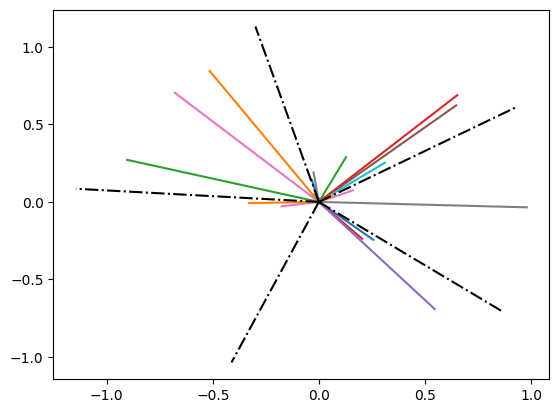

In [270]:
for u_vec in  (eigenmodel_tms.u):
    rep = eigenmodel_tms.vector_to_parameters(u_vec)['W_in'].detach().cpu().numpy()
    for i in rep:
        plt.plot([0,i[0]], [0,i[1]])
    
# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'k-.')
plt.show()

[[[ 0.3 -0.2]
  [-0.  -0. ]
  [-0.   0. ]
  [ 0.2 -0.2]
  [ 0.5 -0.7]]

 [[-0.   0. ]
  [-0.7  0.7]
  [-0.   0.2]
  [-0.   0. ]
  [-0.   0.1]]

 [[-0.   0.1]
  [-0.5  0.8]
  [-0.   0. ]
  [ 0.   0. ]
  [-0.   0. ]]

 [[ 0.6  0.6]
  [ 0.2  0.1]
  [ 0.  -0. ]
  [ 0.   0. ]
  [ 0.3  0.3]]

 [[ 0.  -0. ]
  [ 0.   0. ]
  [ 0.1  0.3]
  [ 0.7  0.7]
  [ 0.   0. ]]

 [[ 0.  -0. ]
  [-0.2 -0. ]
  [ 1.  -0. ]
  [ 0.1  0. ]
  [ 0.   0. ]]

 [[-0.  -0. ]
  [-0.3 -0. ]
  [-0.9  0.3]
  [ 0.   0. ]
  [-0.   0. ]]]
0
1
2
3
4


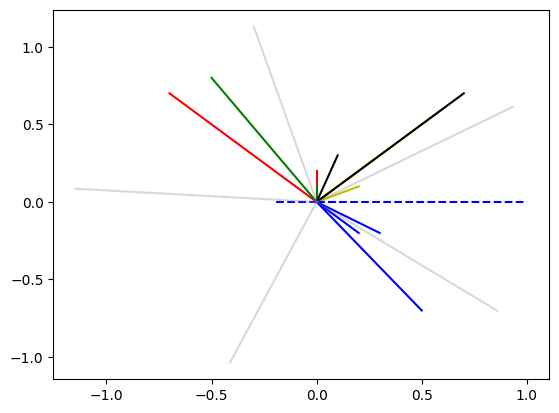

In [271]:
# Plot TMS representations.
en = torch.stack([eigenmodel_tms.vector_to_parameters(u)['W_in'] for u in eigenmodel_tms.u]).detach().cpu().numpy().round(1)
print(en)
hues = ['b-', 'r-', 'g-', 'y-', 'k-', 'b--']
for hue, feature in zip(hues, en):
    for x,y in zip(feature.transpose()[0], feature.transpose()[1]):
      plt.plot([0, x], [0,y], hue, label=hue)

en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

for i in range(en.shape[1]):
  print(i)
  plt.plot([0, en[0,i]], [0,en[1,i]], color='grey', alpha=.3)


plt.xlabel('')
plt.show()

## 2L Transformer

In [3]:
torch.cuda.empty_cache()
gc.collect()

169

In [122]:
#@title Train Eigenmodel
n_u_vectors = 100 
batch_size = 32
lambda_penalty = 1
n_epochs = 2
learning_rate = .01
u_batch_size = 20

torch.cuda.empty_cache()
gc.collect()

x_transformer_dataloader = DataLoader(X_transformer[::100], batch_size=batch_size, shuffle=True)

def custom_loss(x,y):
    squared = x# * (x<1e-5).float()
    return squared

#t0 = time.time()
eigenmodel_transformer = EigenEstimation(transformer_model, 
                         custom_loss, n_u_vectors, u_chunk_size=20).to(device)


TrainEigenEstimation(
    eigenmodel_transformer,
    x_transformer_dataloader,
    lr=learning_rate,
    n_epochs= n_epochs,
    lambda_penalty=lambda_penalty,
    u_batch_size = u_batch_size,
    device = device
)

tensor(-2.2555e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0046, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.1086, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0724, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.1467, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0608, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0679, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.0309, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.1797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.2942, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-0.2114, device='cud

In [56]:
torch.cuda.empty_cache()
gc.collect()

for n,p in transformer_model.named_parameters(): print(n, p.numel())

print(
    abs(torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)
    ).max())
print((
    torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).min()
)
print(abs(
    2*torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).mean()
)

with torch.no_grad():
    for i in range(n_u_vectors):
        print(f'-----{i}-----')
        PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[1::100,:8], i,top_k=5, batch_size=24)


transformer.blocks.4.attn.W_Q 4096
transformer.blocks.4.attn.W_O 4096
transformer.blocks.4.attn.W_K 4096
transformer.blocks.4.attn.W_V 4096
tensor(0.9908, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.9716, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.5102, device='cuda:0', grad_fn=<MeanBackward0>)
-----0-----
 They wanted their mom and dad**.**newline -> . (Value: 1730.935), top: ['\n', ' Then', ' ', '\n\n', ' Sara'], bottom: [' They', ' But', ' She', ' It', ' The']
 screamed. She was scared and sad**.** -> . (Value: 1297.354), top: ['\n', ' Tom', ' ', ' Mom', ' "'], bottom: [' She', ' It', ' He', ' But', ' The']
 big castle. She was not happy**.** -> . (Value: 1213.387), top: ['\n', ' Mom', ' "', ' ', ' Tom'], bottom: [' She', ' It', ' But', ' The', ' There']
 it. They are happy**.**<|endoftext|>L -> . (Value: 1172.325), top: ['\n', ' ', 'Mom', '"', 'They'], bottom: [' They', ' But', ' The', ' We', ' It']
. They knew they were in trouble**.** -> . (Value: 1042.470), top: ['

KeyboardInterrupt: 

In [33]:
n_u_vectors

100

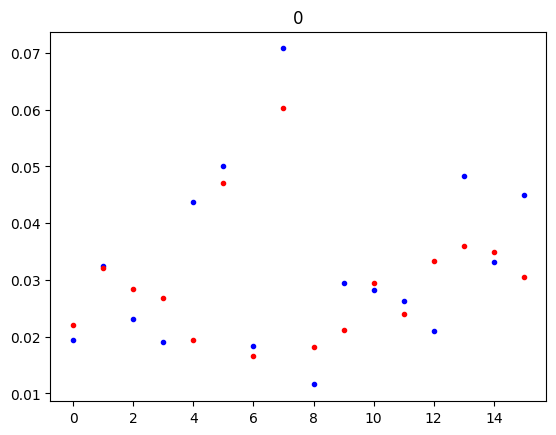

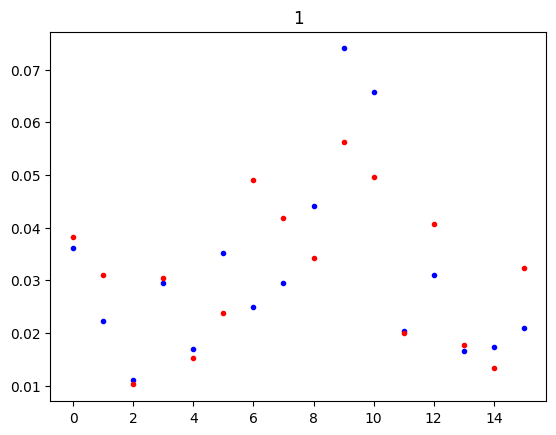

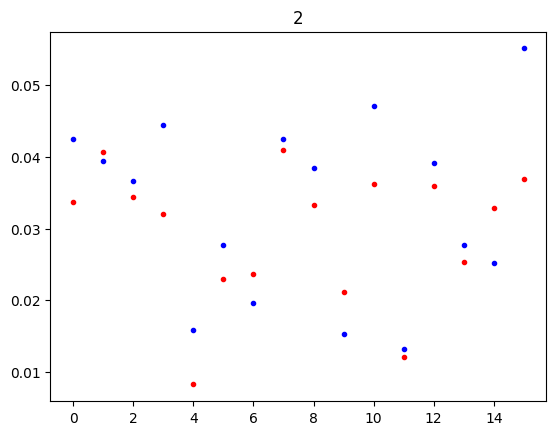

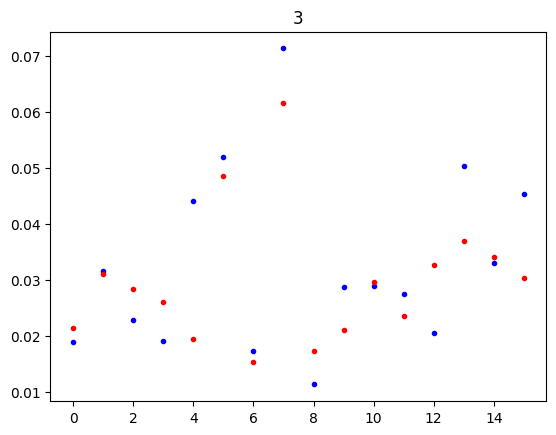

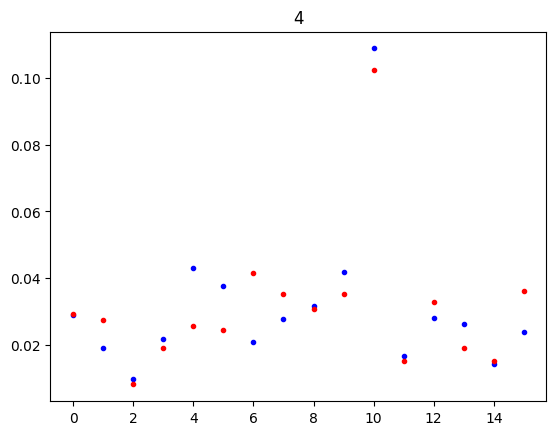

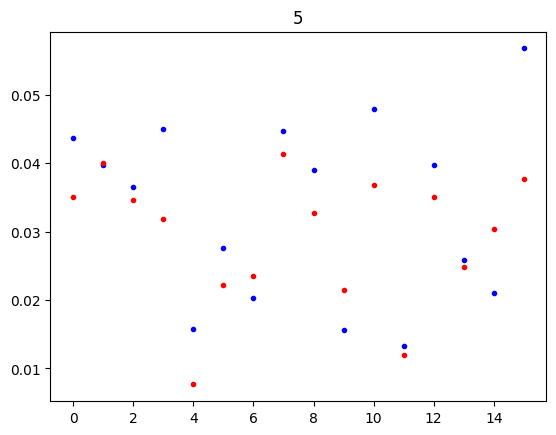

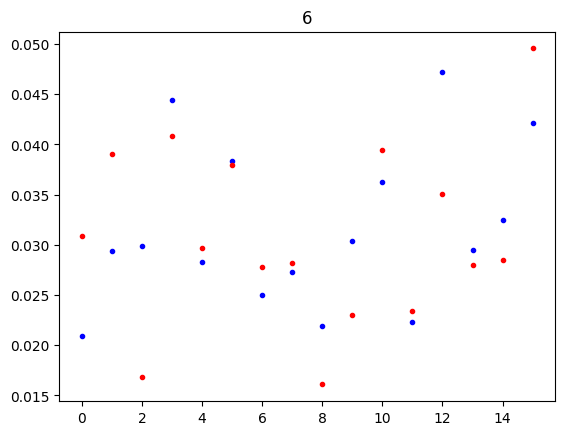

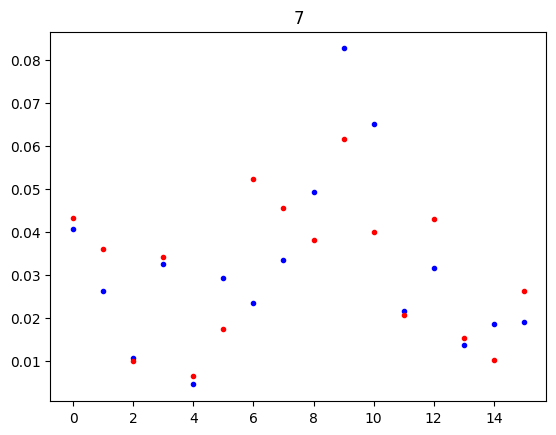

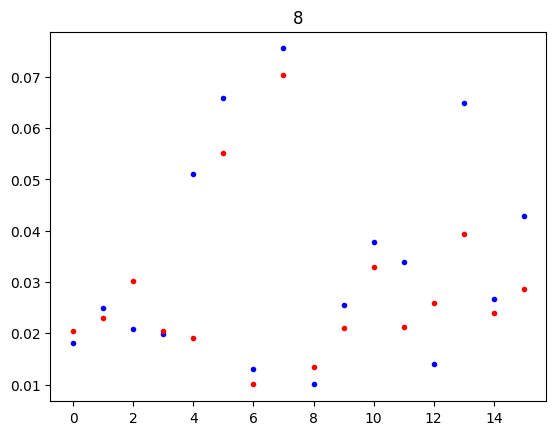

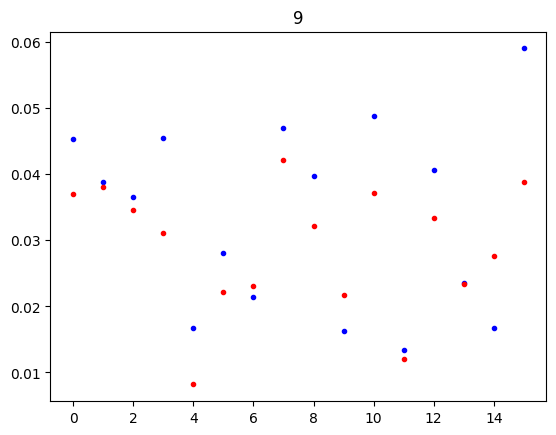

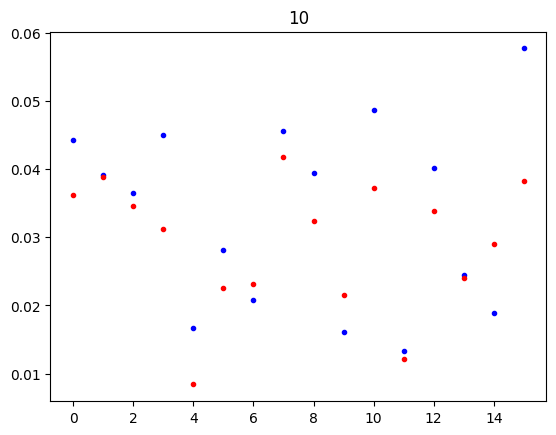

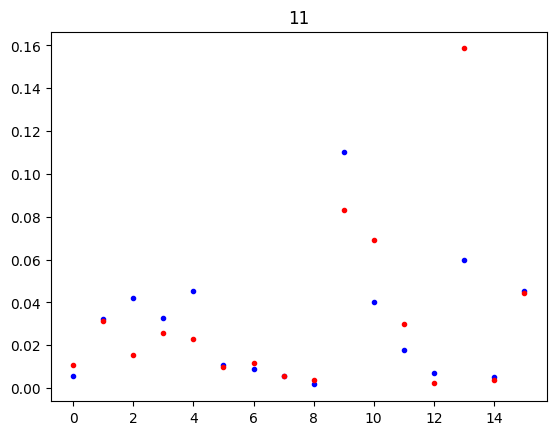

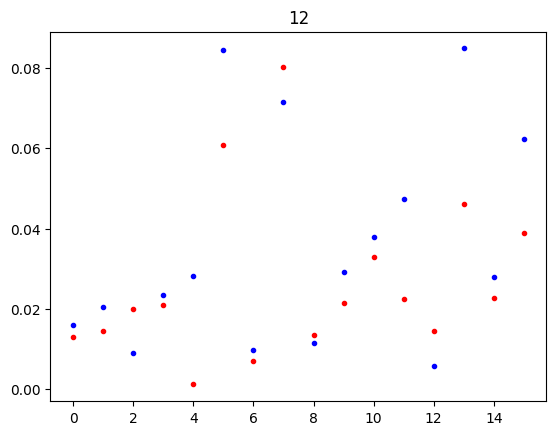

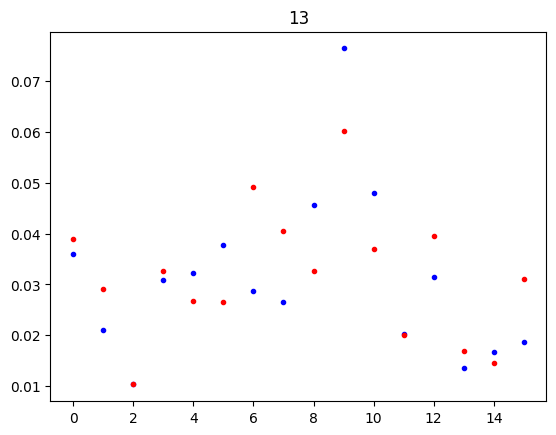

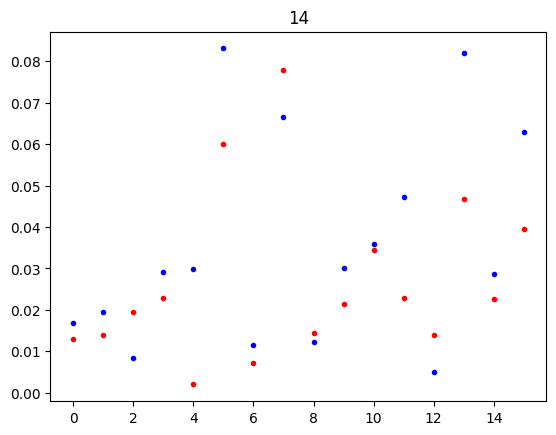

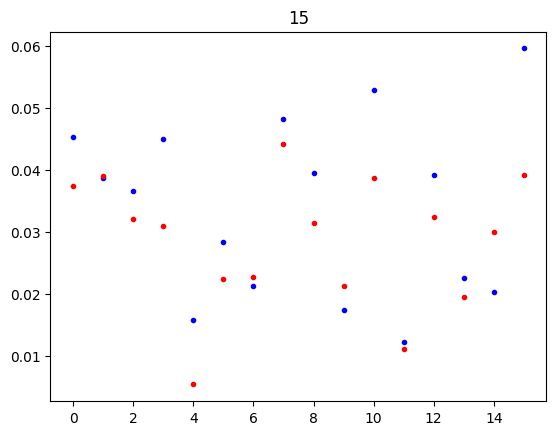

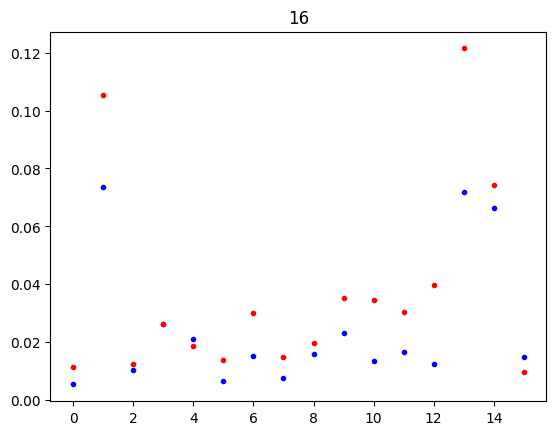

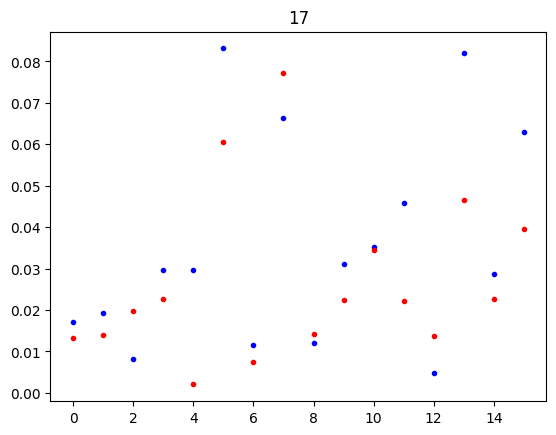

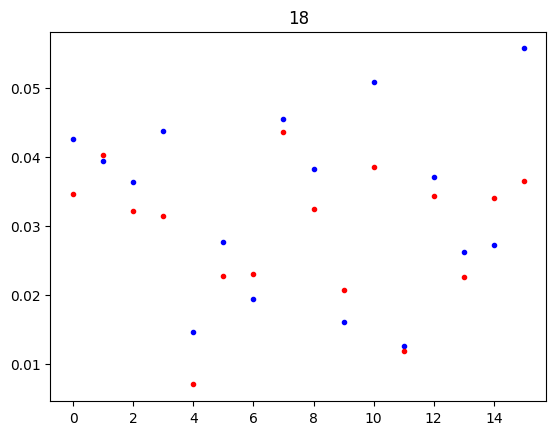

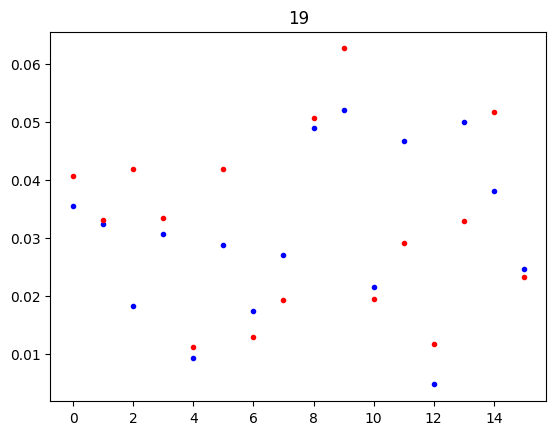

In [323]:
for f_idx in range(20):
    v1, v2 = [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][f_idx].values()
    plt.plot((v1**2).sum(dim=-1).sum(dim=-1).detach().cpu().numpy(), 'b.')
    plt.plot((v2**2).sum(dim=-1).sum(dim=-1).detach().cpu().numpy(), 'r.')#print(name, (vec**2).sum(dim=-1).sum(dim=-1))
    plt.title(f_idx)
    plt.show()

In [301]:
test = transformer_model.transformer
test.cfg

HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': -1.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': ['global',
                'local',
                'global',
                'local',
                'global',
                'local',
                'global',
                'local'],
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 4,
 'd_mlp': 256,
 'd_model': 64,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': np.float64(0.1),
 'load_in_4bit': False,
 'model_name': 'TinyStories-1M',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 16,
 'n_key_value_heads': None,
 'n_layers': 8,
 'n_pa

In [290]:
vec.shape

torch.Size([16, 64, 4])

In [252]:
torch.cuda.empty_cache()
gc.collect()

import numpy as np
for i in range(10):
    print([(v**2).sum(dim=0).sum(dim=0) for v in [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][i].values()])
    #a = [(v**2).sum().item() for v in [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][i].values()]
    #plt.plot(a, label=i)
    #plt.show()
    #plt.hist(eigenmodel_transformer.u[i].detach().cpu().numpy(), bins=100)
    #plt.show()
#plt.legend()
#plt.show()

[tensor([0.1428, 0.1338, 0.1355, 0.1078], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1244, 0.1247, 0.1137, 0.1172], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.0974, 0.1381, 0.1110, 0.1493], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1396, 0.1182, 0.1172, 0.1292], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1319, 0.1085, 0.1400, 0.1495], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1259, 0.1076, 0.1154, 0.1213], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1439, 0.1353, 0.1347, 0.1091], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1242, 0.1240, 0.1128, 0.1160], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1227, 0.1301, 0.1049, 0.1438], device='cuda:0',
       grad_fn=<SumBackward1>), tensor([0.1326, 0.1241, 0.1042, 0.1377], device='cuda:0',
       grad_fn=<SumBackward1>)]
[tensor([0.1309, 0.1092, 0.1413, 0.1513], device='cuda:0',
       grad_fn=<SumBackward1>), tens

In [1]:
dH_du_tensor = eigenmodel_transformer(X_transformer[:32], eigenmodel_transformer.u).transpose(0,1)
#print(dH_du_tensor.shape)
u_tensor = eigenmodel_transformer.u
cosine_sims = u_tensor @ u_tensor.transpose(0,1)
prod = einops.einsum(dH_du_tensor, dH_du_tensor, 'k1 ... , k2 ...->... k1 k2')
print(prod.shape, cosine_sims.shape)
prod_cosin_sims = einops.einsum(prod, cosine_sims, '... k1 k2, k1 k2 ->... k1 k2')

NameError: name 'eigenmodel_transformer' is not defined

In [52]:

torch.cuda.empty_cache()
gc.collect()

def custom_loss(x,y):
    print(x.shape)
    squared = x**2 * (x<1e-5).float()
    print(squared.shape)
    return squared

eigenmodel_transformer = EigenEstimation(transformer_model, 
                         custom_loss, 100, u_chunk_size=20).to(device)


def test(x, us):
    print('doing this!')
    return jvp(partial(eigenmodel_transformer.compute_loss, x), (eigenmodel_transformer.w0,), (us,))[1]


#test(X_transformer[:2,:2], eigenmodel_transformer.u[2])
import time
t= time.time()
#transformer_model(X_transformer[:10,:10])
#eigenmodel_transformer.compute_loss(X_transformer[:10,:8], eigenmodel_transformer.w0)
a = vmap(test, in_dims=(None, 0), out_dims=0, chunk_size=20)(X_transformer[:32], eigenmodel_transformer.u[:100])
print(a.shape)
result = einops.einsum(a, a, 'v batch tokens ps, v batch tokens ps -> v batch tokens')
jr = jacrev(eigenmodel_transformer.compute_loss, argnums=1, chunk_size=10)(
    X_transformer[:8], eigenmodel_transformer.w0,)
#jr = test(X_transformer[:48,:4], eigenmodel_transformer.u[1])
#print(a.shape,'here')
#result = einops.einsum(jr, eigenmodel_transformer.u, '... w, v w -> ... v')
#
# print(result.shape)
#test = einops.einsum(result, result,'v batch1 tokens1, v batch2 tokens2 -> batch1 batch2 tokens1 tokens2')
#diagonal = torch.diagonal(test, dim1=0, dim2=1)
#diagonal.zero_()
#test = test/result.shape[0]
#print(result.sum())
#print(test.sum())
#print(result)
print(time.time()-t)
#print(test)
#jvp(partial(eigenmodel_transformer.compute_loss, ), (eigenmodel_transformer.w0,), (eigenmodel_transformer.u[2],))[1].shape

doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
doing this!
torch.Size([32, 8, 50257])
torch.Size([32, 8, 50257])
torch.Size([100, 32, 8, 50257])
0.5966215133666992


In [24]:
    from torch.func import jacrev, functional_call, jvp, vmap, jacrev
    torch.cuda.empty_cache()
    gc.collect()

    def compute_loss(
        x: torch.Tensor, parameters: torch.Tensor
    ) -> torch.Tensor:
        # Perform a stateless functional call to the model with given parameters
        param_dict = eigenmodel_transformer.vector_to_parameters(parameters)
        outputs: torch.Tensor = functional_call(eigenmodel_transformer.model, param_dict, (x,))
        # Detach outputs to prevent gradients flowing back
        with torch.no_grad():
            truth: torch.Tensor = eigenmodel_transformer.model(x,)

        # CrossEntropyLoss needs to be of form (_, n_classes, ...)        
        #outputs = einops.rearrange(outputs, '... c -> c ...').unsqueeze(0)
        #truth = einops.rearrange(truth, '... c -> c ...').unsqueeze(0)

        # Compute the loss without reduction
        return eigenmodel_transformer.loss(outputs[:2], truth[:2])#.squeeze(0)

    jr = jacrev(compute_loss, argnums=1, chunk_size=1000)(
        X_transformer[:10,:2], eigenmodel_transformer.w0,)

In [16]:
eigenmodel_transformer.w0.shape

torch.Size([8192])

In [65]:
a.max()

tensor(8.9725e-08, device='cuda:0', grad_fn=<MaxBackward1>)

In [210]:
jvp(partial(eigenmodel_transformer.compute_loss, X_transformer[:10,:10]), (eigenmodel_transformer.w0,), (eigenmodel_transformer[:10,:10].u[1],))[1]

TypeError: 'EigenEstimation' object is not subscriptable

In [205]:
partial(eigenmodel_transformer.compute_loss, X_transformer[:10,:10]) (eigenmodel_transformer.w0,).shape

torch.Size([10, 8, 50257])

In [208]:
def test(x, us):
    print('doing this!')
    return jvp(partial(compute_loss, x), (eigenmodel_transformer.w0,), (us,))[1]

def func(w):
    partial(eigenmodel_transformer.compute_loss, x) (eigenmodel_transformer.w0,)

torch.autograd.functional.jacobian(
    partial(eigenmodel_transformer.compute_loss,
    X_transformer[:10,:10]), (eigenmodel_transformer.w0,), create_graph=False, vectorize=True,strategy='forward-mode')

OutOfMemoryError: CUDA out of memory. Tried to allocate 61.35 GiB. GPU 0 has a total capacity of 39.38 GiB of which 10.07 GiB is free. Including non-PyTorch memory, this process has 29.30 GiB memory in use. Of the allocated memory 16.49 GiB is allocated by PyTorch, and 12.32 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [194]:
jr.shape

torch.Size([3, 2, 50257, 4096])

In [185]:
eigenmodel_transformer.w0.requires_grad_(True)
A = eigenmodel_transformer.compute_loss(X_transformer[:10], eigenmodel_transformer.w0)
print(A.flatten())
eigenmodel_transformer.w0.requires_grad_(True)
jvp = torch.autograd.grad(A.flatten(), eigenmodel_transformer.w0)#, grad_outputs=eigenmodel_transformer.u[:2], retain_graph=False)


tensor([1.0469, 2.6363, 1.3793, 3.5012, 1.8782, 1.8265, 1.3879, 1.0285, 1.7043,
        2.3596], device='cuda:0', grad_fn=<SumBackward1>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
torch.autograd.grad(vjp_flat, u, grad_outputs=v, retain_graph=False)

In [12]:
transformer_model(X_transformer[:32,:24]).shape

torch.Size([32, 8, 50257])

In [11]:
X_transformer[:32,:24]

tensor([[32565,    13, 15899,  2497,   262, 22441,  1097,   290],
        [  531,    11,   366, 22017,    11, 21168,    11,   534],
        [ 1097,   318,   523,  6016,   290,  3424,  2474, 21168],
        [13541,   290,  8712,    11,   366, 10449,   345,    11],
        [15899,    13,   314, 25245,   340,   790,  1110,   526],
        [  198,   198,  3260,  2712,   351,   262,  1097,    11],
        [21168,   290, 15899,  2936, 47124,    13,  1119,  1043],
        [  257,  1402, 16723,   351,  1598,  1660,    13,  1119],
        [24070,   262,  1660,   290,  2936,   845,  3772,    13],
        [ 1119,  2826,  1978,   477,  1110,   290,  2627,  1266],
        [ 2460,    13, 50256,  7454,  2402,   257,   640,    11],
        [  287,   257,  1263,  8222,    11,   612,  5615,   257],
        [ 9529,   259,   420, 27498,  3706,   371, 23536,    13],
        [  371, 23536,  6151,   284, 12080,    13,  1375, 19952],
        [ 7150,    11, 12586,    11,   290, 18639,    13,  1881],
        [ 

tensor([[[-8.5894e+01, -2.3941e+00, -1.1500e+01,  ..., -7.6702e+00,
          -5.5782e+01, -1.2205e+01],
         [-9.6746e+00,  7.1325e+01, -3.6352e+01,  ...,  4.5261e+01,
          -2.3040e+01,  3.6567e+01],
         [-3.3833e+01,  2.7846e+01,  4.0171e+01,  ..., -4.3040e+01,
           1.4843e+02, -2.6281e+01],
         ...,
         [ 2.8213e+01, -5.1905e+00,  2.9090e+00,  ...,  2.5676e+00,
           2.8102e+01, -1.8393e+01],
         [-5.8760e+01,  1.9943e+02, -7.0192e+01,  ..., -1.1632e+02,
          -1.9838e+01,  7.7984e+01],
         [ 6.4258e+01, -1.3235e+02, -6.4691e-02,  ..., -2.0529e+02,
          -1.5658e+02, -9.6852e+01]],

        [[ 1.8510e+02, -9.0249e+01,  6.9382e+01,  ...,  2.7165e+01,
           7.3389e+01,  2.4455e+02],
         [-4.1367e+01,  3.2348e+01, -1.6189e+02,  ...,  1.6565e+02,
           3.2797e+01, -5.8197e+01],
         [-1.7341e+01, -2.0934e+01, -2.2331e+00,  ...,  1.8623e+01,
           4.6183e+01,  2.5598e+01],
         ...,
         [-1.4336e+02, -1

In [209]:
eigenmodel_transformer = EigenEstimation(transformer_model.to(device), 
                         lambda x,y: x[...,:15], 1000, u_chunk_size=20).to(device)

In [172]:
torch.cuda.empty_cache()
gc.collect()

0

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 GiB. GPU 0 has a total capacity of 39.38 GiB of which 11.99 GiB is free. Including non-PyTorch memory, this process has 27.38 GiB memory in use. Of the allocated memory 24.54 GiB is allocated by PyTorch, and 2.35 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [144]:
diagonal.shape

torch.Size([8, 8, 32])

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.3808e+10, 1.4676e+10, 5.9526e+10,  ..., 1.1504e+11,
           9.3946e+10, 2.9889e+10],
          [3.7045e+10, 2.0861e+10, 7.3973e+10,  ..., 1.3449e+11,
           1.2811e+11, 3.3928e+10],
          [8.7924e+10, 4.0123e+10, 1.4115e+11,  ..., 2.5739e+11,
           2.5404e+11, 7.7876e+10],
          ...,
          [5.8286e+10, 3.1464e+10, 9.4514e+10,  ..., 2.5262

In [105]:
torch.combinations(torch.arange(batch_size), r=2).shape

torch.Size([496, 2])

In [99]:
batch_size = tensor.size(0)
indices = torch.combinations(torch.arange(result.size(1)), r=2)

# Extract the elements where batch1 != batch2
selected_elements = torch.stack([tensor[i, j] for i, j in indices])


tensor([[[[4.0040e+10, 3.2041e+10, 6.4844e+10,  ..., 4.8275e+10,
           9.5809e+10, 1.1833e+11],
          [3.2041e+10, 7.3487e+10, 8.9767e+10,  ..., 7.3261e+10,
           1.4204e+11, 1.6520e+11],
          [6.4844e+10, 8.9767e+10, 3.3806e+11,  ..., 1.2906e+11,
           2.5000e+11, 2.9890e+11],
          ...,
          [4.8275e+10, 7.3261e+10, 1.2906e+11,  ..., 1.7535e+11,
           1.8264e+11, 2.1204e+11],
          [9.5809e+10, 1.4204e+11, 2.5000e+11,  ..., 1.8264e+11,
           1.2541e+12, 5.7197e+11],
          [1.1833e+11, 1.6520e+11, 2.9890e+11,  ..., 2.1204e+11,
           5.7197e+11, 1.0471e+12]],

         [[3.3808e+10, 1.4676e+10, 5.9526e+10,  ..., 1.1504e+11,
           9.3946e+10, 2.9889e+10],
          [3.7045e+10, 2.0861e+10, 7.3973e+10,  ..., 1.3449e+11,
           1.2811e+11, 3.3928e+10],
          [8.7924e+10, 4.0123e+10, 1.4115e+11,  ..., 2.5739e+11,
           2.5404e+11, 7.7876e+10],
          ...,
          [5.8286e+10, 3.1464e+10, 9.4514e+10,  ..., 2.5262

In [116]:
torch.cuda.empty_cache()
gc.collect()
#for n, p in eigenmodel_transformer.model.named_parameters(): print(n, p.numel())
#print('\n')
for i in list(range(min(10,eigenmodel_transformer.n_u_vectors))):
  print(i)
  PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[:100], i, 5, 64, device)
  print('\n')

0
 Kitty and** Spot** felt thirsty. They found ->  Spot (Value: 63482.133)
,** Sue**, for being so thoughtful and ->  Sue (Value: 41138.707)
 a name. Her** name** was Daisy. ->  name (Value: 41049.613)
 careful."** Sue** felt proud that she could ->  Sue (Value: 39540.402)
 His** name** was Max. Max liked to ->  name (Value: 35068.254)


1
?" Her mom said,** "**Yes, ->  " (Value: 252338.953)
 smiled and replied,** "**Thank you, ->  " (Value: 165065.750)
 said,** "**Wow, Kitty, your ->  " (Value: 86251.016)
 it. Billy said,** "**I have ->  " (Value: 67452.812)
 mom, so she said,** "**Mom ->  " (Value: 61045.062)


2
, Sue, for being so thoughtful** and** ->  and (Value: 54741.414)
 Kitty** and** Spot felt thirsty. They found ->  and (Value: 17642.449)
 help from a friend**,** she could climb -> , (Value: 16558.445)
 car is so bright** and** clean!" Kitty ->  and (Value: 16394.727)
 Roxy was sad** and** asked, " ->  and (Value: 12962.355)


3
, Sue, for being so thoughtful** and** ->  an

In [113]:
print(
    abs(torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)
    ).max())
print((
    torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).min()
)
print(abs(
    2*torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).mean()
)

tensor(0.6975, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.3381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0651, device='cuda:0', grad_fn=<MeanBackward0>)


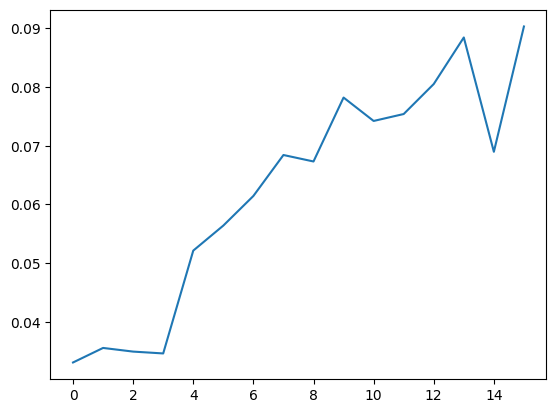

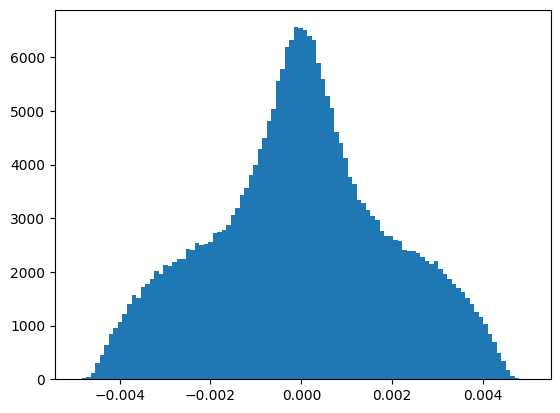

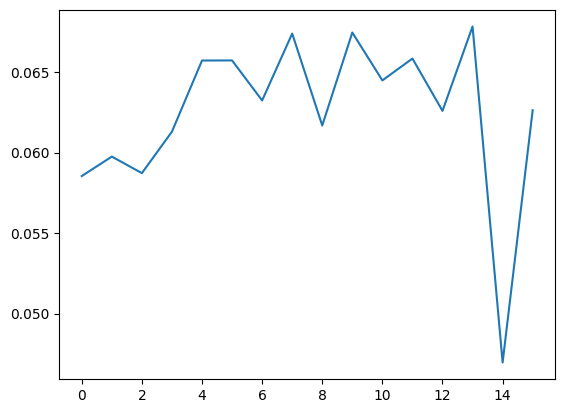

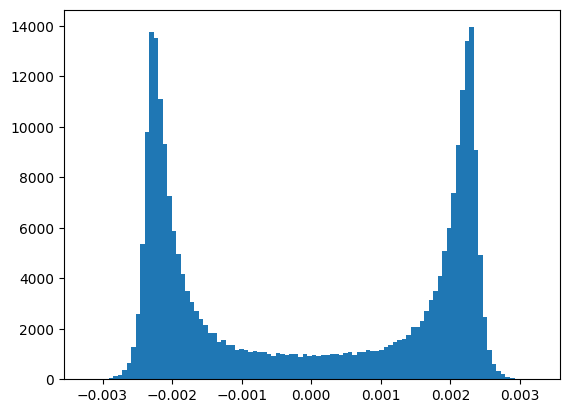

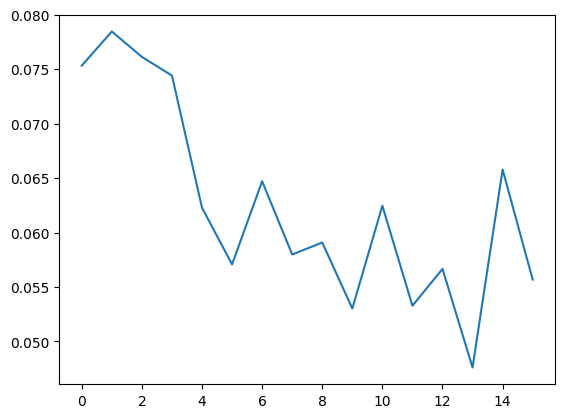

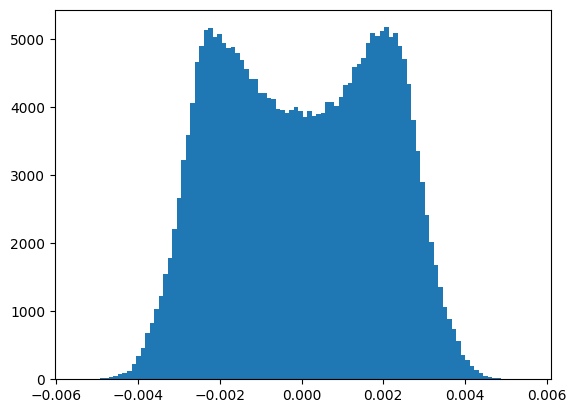

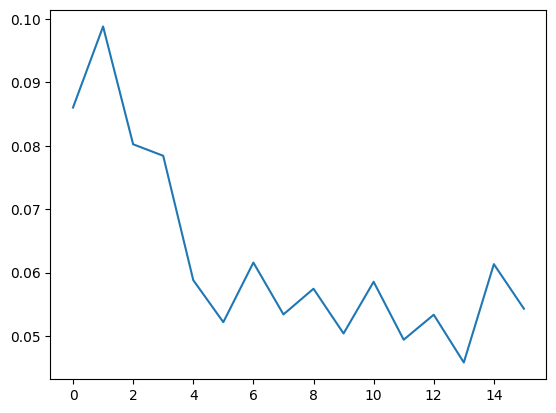

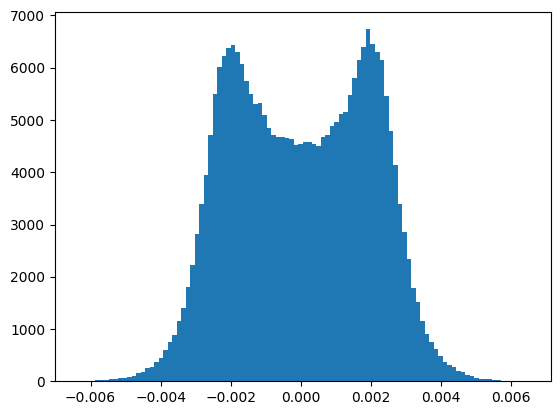

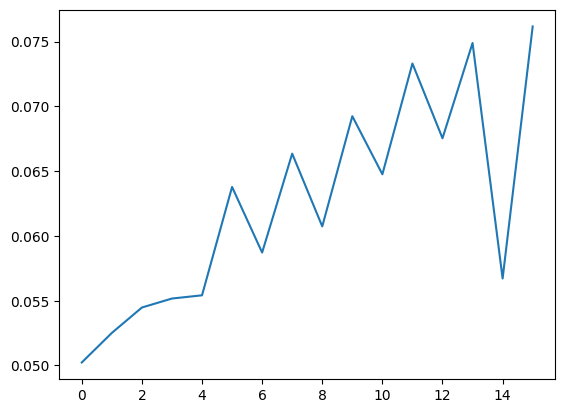

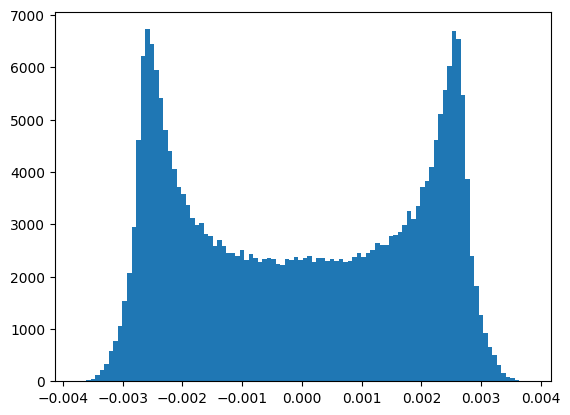

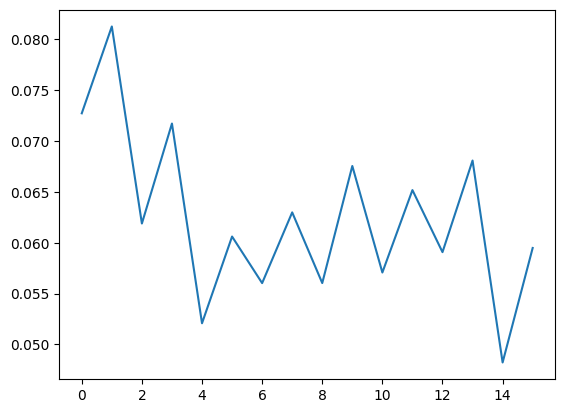

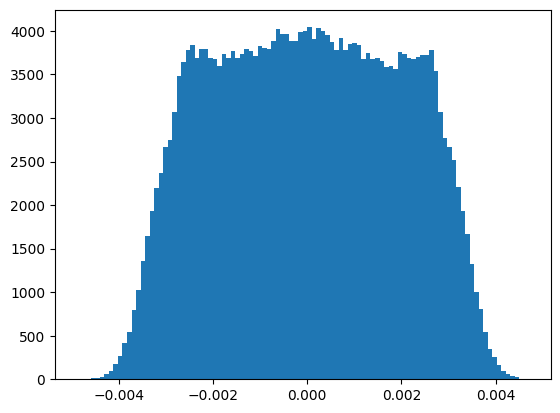

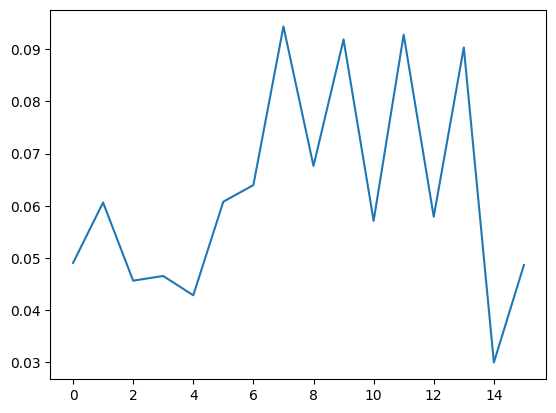

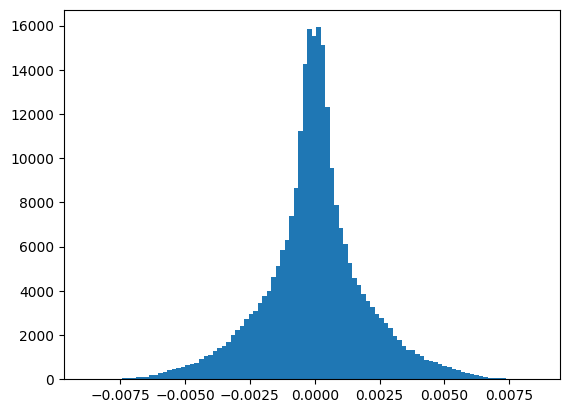

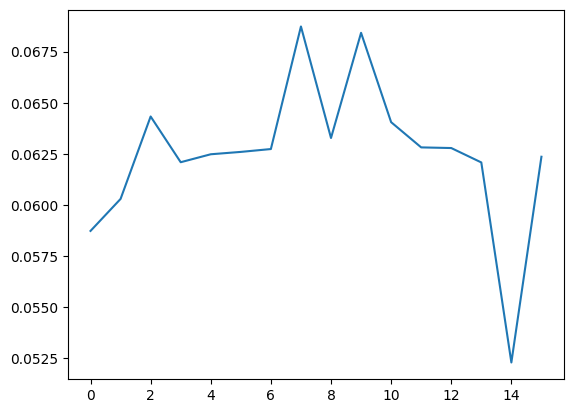

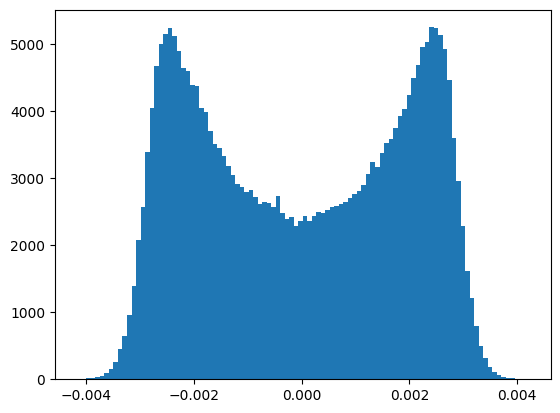

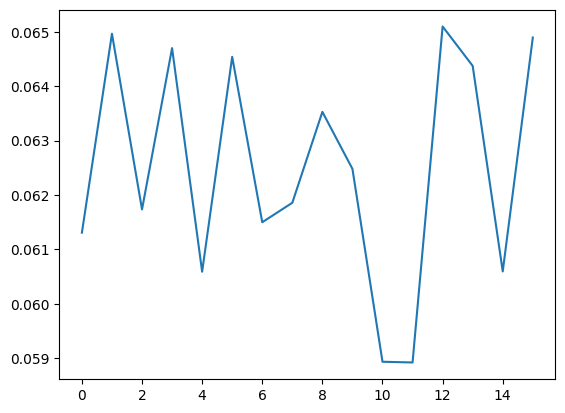

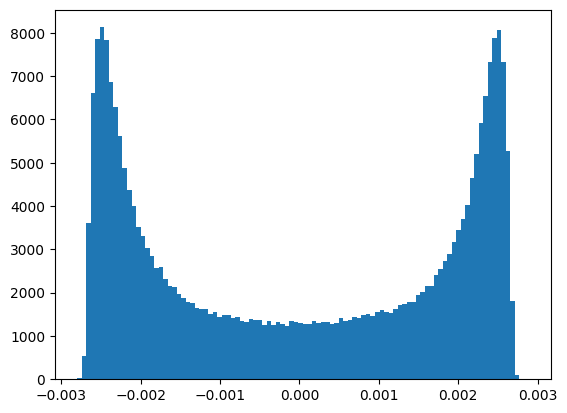

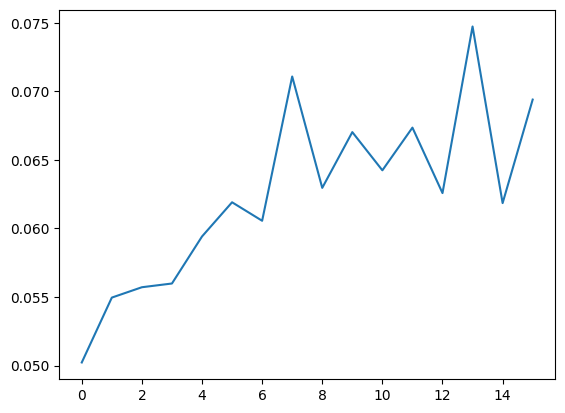

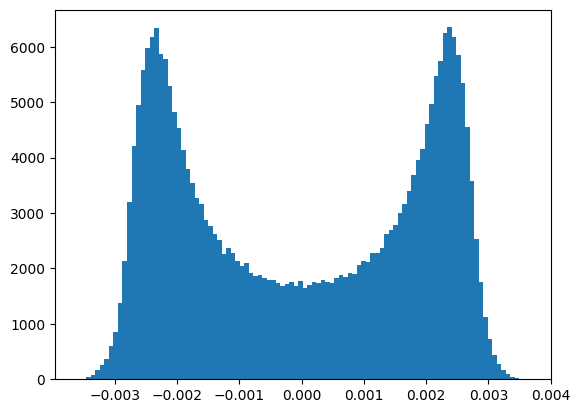

/tmp/ipykernel_14209/1493639938.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


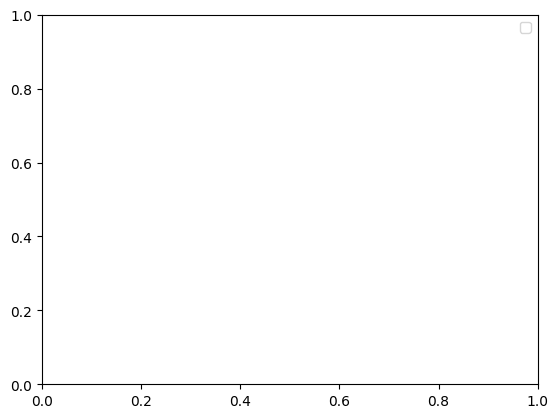

In [118]:
import numpy as np
for i in range(10):
    #print([(v**2).sum(dim=0).sum(dim=0) for v in [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][i].values()])
    a = [(v**2).sum().item() for v in [eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u][i].values()]
    plt.plot(a, label=i)
    plt.show()
    plt.hist(eigenmodel_transformer.u[i].detach().cpu().numpy(), bins=100)
    plt.show()
plt.legend()
plt.show()

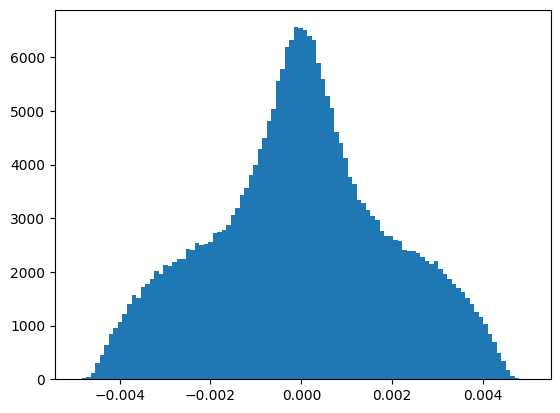

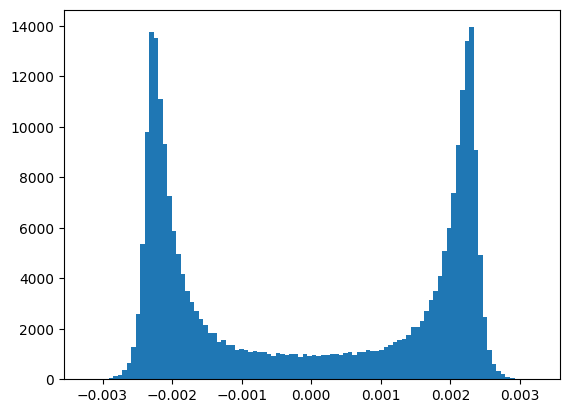

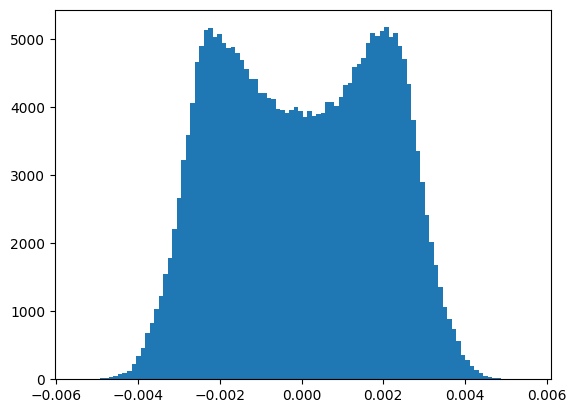

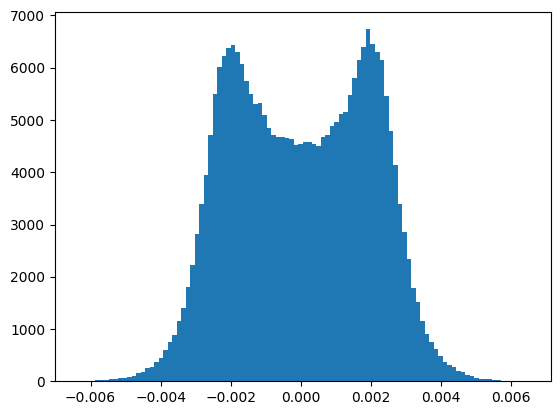

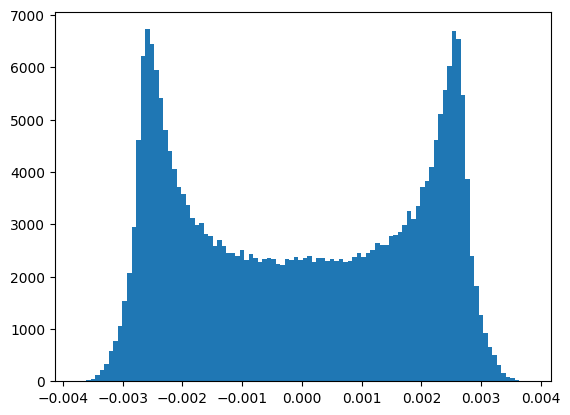

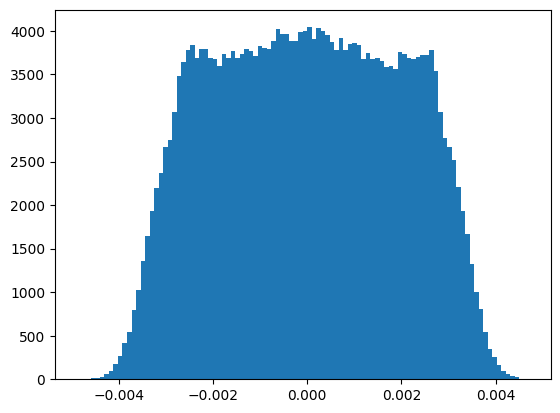

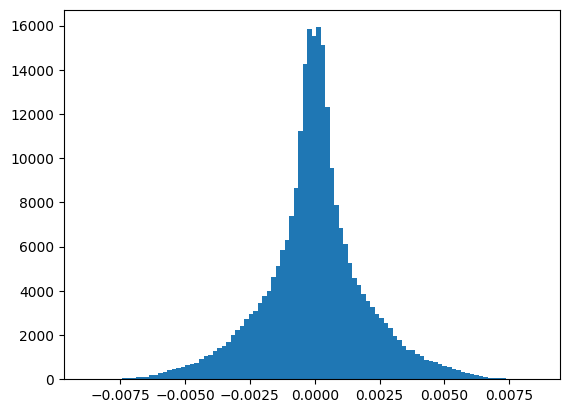

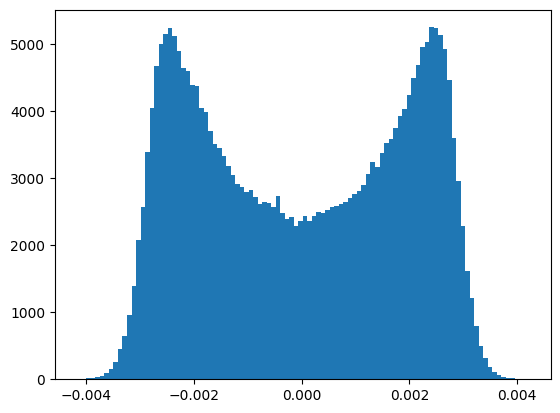

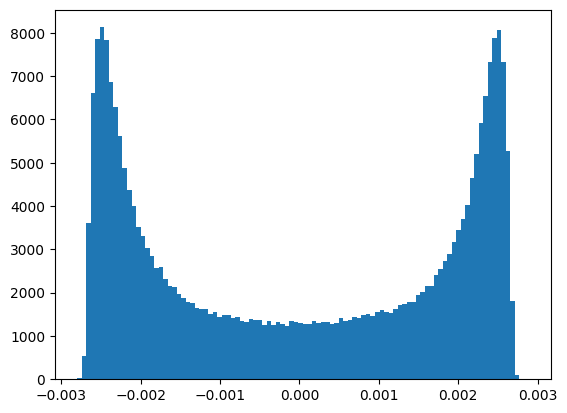

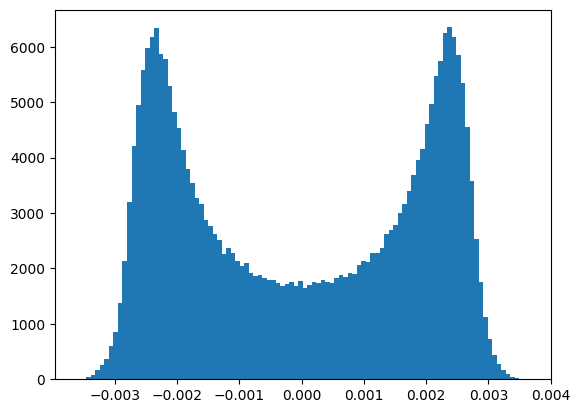

In [117]:
for i in range(10):


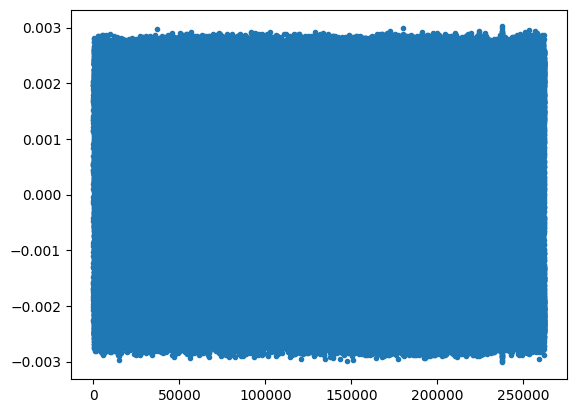

In [94]:
plt.plot(eigenmodel_transformer.u[1].detach().cpu().numpy(), '.')

In [74]:
a = [(v).min() for v in [eigenmodel_transformer.vector_to_parameters(u).max for u in eigenmodel_transformer.u][i].values()]
a


[tensor(-0.0061, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0081, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0100, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0073, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0094, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0090, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0089, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0105, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0083, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0093, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0084, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0094, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0076, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0084, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0075, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0073, device='cuda:0', grad_fn=<MinBackward1>)]

In [67]:
[eigenmodel_transformer.vector_to_parameters(u) for u in eigenmodel_transformer.u]

[{'transformer.blocks.0.mlp.W_in': tensor([[-1.3205e-03, -2.9461e-03, -2.0559e-03,  ...,  1.5030e-03,
            7.4706e-04, -1.2017e-03],
          [ 1.6316e-03, -1.0609e-03, -1.6277e-04,  ..., -4.8691e-04,
            2.1574e-03,  3.6203e-05],
          [-1.7578e-03, -3.7235e-03,  6.4231e-04,  ...,  3.8598e-04,
            3.9778e-03, -4.0833e-04],
          ...,
          [ 2.7493e-04,  2.4098e-03, -8.4977e-04,  ..., -1.6529e-04,
           -3.2727e-03,  9.8231e-04],
          [ 1.9920e-03, -9.6080e-04, -4.5718e-04,  ..., -1.3762e-03,
            9.9260e-04,  3.3829e-04],
          [-1.1665e-03, -4.0125e-03, -7.8051e-04,  ...,  2.2302e-03,
            1.1028e-03, -4.3656e-04]], device='cuda:0', grad_fn=<ViewBackward0>),
  'transformer.blocks.0.mlp.W_out': tensor([[-8.2215e-04, -1.3202e-03,  1.3648e-03,  ...,  2.8140e-03,
           -9.5458e-05, -1.4137e-03],
          [-1.9015e-05, -1.7663e-03, -2.7782e-04,  ...,  7.4476e-04,
            1.6466e-03,  2.4503e-03],
          [-5.0714

# SCRATCH

In [6]:
import torch
from torch.func import vmap, vjp, grad

# Define a function with parameters and inputs
def f(x, params):
    # Example function with parameters (a simple linear combination)
    return (x * params).sin().sum()

# HVP function that takes parameters
def hvp_revrev(f, primals, params, *tangents):
    # Compute gradient of f with respect to params only
    grad_f = grad(lambda p: f(primals, p))#(params)
    # Perform VJP to get HVP
    _, vjp_fn = vjp(lambda p: grad_f(primals, p), params)
    print(*tangents)
    return vjp_fn(*tangents)

# Batch sizes for inputs and parameters
batch_size = 2048
num_tangents = 10

# Sample inputs and parameters
x_batch = torch.randn((10, 2), requires_grad=False)  # Input, no gradient needed
params = torch.randn(2, requires_grad=True)    # Parameters to differentiate
tangent_batch = torch.randn((3, 2))   # Tangents for each parameter

print(hvp_revrev(f, x_batch[1,:], params, tangent_batch[1,:]))

# Vectorize over both the parameters (tangents) and input samples
batched_hvp = vmap(lambda t: hvp_revrev(f, x_batch, t, params))(tangent_batch)

print(batched_hvp)


TypeError: hvp_revrev.<locals>.<lambda>() takes 1 positional argument but 2 were given

In [ ]:
#@title Eigenestimation.py

import torch
import torch.nn as nn
from torch.nn.utils import stateless
from torch.func import jacrev, functional_call, jvp, vmap
import einops
from typing import Any, Dict, List, Tuple, Callable
import gc
from functools import partial 

class EigenEstimation(nn.Module):
    def __init__(self, model: nn.Module, loss: Callable, n_u_vectors: int, u_chunk_size=10) -> None:
        super(EigenEstimation, self).__init__()

        self.model: nn.Module = model
        self.loss: Callable = loss
        self.n_u_vectors: int = n_u_vectors
        self.named_parameters = {name: param.detach().clone() for name, param in model.named_parameters()}
        self.w0 = self.parameters_to_vector(self.named_parameters)
        self.u = nn.Parameter(torch.randn((n_u_vectors, len(self.w0))).requires_grad_(True))
        self.u_chunk_size = u_chunk_size


        # Register u vectors as parameters with modified names
        #for name, tensor in u_dict.items():
        #    self.register_parameter(name.replace('.', '__'), tensor)

    def parameters_to_vector(self, named_parameters):
        return torch.cat([param.view(-1) for name, param in named_parameters.items()])

    # Restore parameters from a vector to the dictionary format
    def vector_to_parameters(self, vector):
      # Create an iterator to slice vector based on parameter shapes
      pointer = 0
      new_params = {}
        
      for name, param in self.named_parameters.items():
        numel = param.numel()  # Number of elements in this parameter
        # Slice out `numel` elements from the vector
        new_params[name] = vector[pointer:pointer + numel].view(param.shape)
        pointer += numel
      return new_params
    


    def compute_loss(
        self, x: torch.Tensor, parameters: torch.Tensor
    ) -> torch.Tensor:
        # Perform a stateless functional call to the model with given parameters
        param_dict = self.vector_to_parameters(parameters)
        outputs: torch.Tensor = functional_call(self.model, param_dict, (x,))
        # Detach outputs to prevent gradients flowing back
        with torch.no_grad():
            truth: torch.Tensor = self.model(x,)

        # CrossEntropyLoss needs to be of form (_, n_classes, ...)        
        #outputs = einops.rearrange(outputs, '... c -> c ...').unsqueeze(0)
        #truth = einops.rearrange(truth, '... c -> c ...').unsqueeze(0)

        # Compute the loss without reduction
        return self.loss(outputs, truth)#.squeeze(0)

    def double_grad_along_u(
        self, x: torch.Tensor, u: torch.Tensor
    ) -> torch.Tensor:

        # Compute the first derivative along u.
        def inner_jvp(w0):
          return jvp(
              partial(self.compute_loss, x), (w0,), (u,)
              )[1]
              
        # Compute the second derivative along u.
        return inner_jvp(w0)#jvp(inner_jvp, (self.w0,), (u,))[1]

    def vmap_double_grad_along_u(self, x, us):
      return vmap(self.double_grad_along_u, in_dims=(None, 0), out_dims=0, chunk_size=self.u_chunk_size)(x, us)

    def normalize_parameters(self, eps=1e-6) -> None:
      # Concatenate all parameters into a single tensor
      with torch.no_grad():
        self.u.div_(eps+self.u.norm(keepdim=True, dim=1).detach())


    def forward(self, x: torch.Tensor, parameters) -> Tuple[torch.Tensor, torch.Tensor]:
        # Compute the double gradient along u
        dH_du: torch.Tensor = self.vmap_double_grad_along_u(x, parameters)

        return dH_du
        

tensor([[[1.2665e-05, 3.5798e-06, 9.0556e-09,  ..., 8.9228e-11,
          5.4186e-08, 1.1135e-03],
         [1.4161e-03, 6.3992e-05, 1.4197e-08,  ..., 1.6627e-09,
          5.7188e-07, 1.9373e-02],
         [9.0320e-04, 5.7202e-06, 1.1879e-06,  ..., 3.5577e-08,
          3.3679e-07, 3.8889e-04],
         [3.5283e-07, 6.2039e-06, 4.4846e-08,  ..., 1.1274e-09,
          3.1445e-08, 2.2425e-06],
         [1.9373e-02, 3.8199e-04, 8.1766e-08,  ..., 2.9981e-09,
          2.7838e-07, 2.7301e-07]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [222]:
import torch
from torch.func import jvp, grad, vjp, jacrev, jacfwd, functional_call, vmap
from torch import vmap
import torch
import torch.nn as nn
from torch.amp import autocast

n_features = 24


import torch.profiler

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True
) as prof:

    # Define the neural network
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            # Define two hidden layers with 12 nodes each
            self.hidden1 = nn.Linear(n_features, 12)  # 1 input node to 12 hidden nodes
            self.hidden2 = nn.Linear(12, 11) # 12 hidden nodes to 12 hidden nodes
            self.output = nn.Linear(11, 24)   # 12 hidden nodes to 1 output node

        def forward(self, x):
            x = torch.relu(self.hidden1(x))  # ReLU activation function for first layer
            x = torch.relu(self.hidden2(x))  # ReLU activation function for second layer
            x = self.output(x)               # Output layer without activation (regression)
            return x

    # Initialize the model
    #model = transformer_model#


    import torch

    # Flatten model parameters into a single vector
    def parameters_to_vector(named_parameters):
        return torch.cat([param.view(-1) for name, param in named_parameters.items()])

    # Restore parameters from a vector to the dictionary format
    def vector_to_parameters(vector, named_parameters):
        # Create an iterator to slice vector based on parameter shapes
        pointer = 0
        new_params = {}
        for name, param in named_parameters.items():
            numel = param.numel()  # Number of elements in this parameter
            # Slice out `numel` elements from the vector
            new_params[name] = vector[pointer:pointer + numel].view(param.shape)
            pointer += numel
        return new_params
    


    # Define a function with both inputs and parameters
    def f(X, params):
        # An example function using parameters (e.g., element-wise sine with params)
        with torch.no_grad():
            ans =  functional_call(model, vector_to_parameters(params, template), X)
        #with autocast(device):
        return ans.sum(dim=-1)


    # Function to compute the Hessian-vector product with respect to parameters
    def hvp_revrev(f, X, params, tangents):
        ans = jvp(
            lambda pp: jvp(
                lambda p: f(X,p), (pp,), (tangents,)
                )[1], 
                (params,), (tangents,))[1]
        return ans.detach()




    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.reset_max_memory_allocated()

    print(torch.cuda.max_memory_allocated()/1024**3)
    # Initialize input and parameters
    batch_size = 64
    n_vectors = 5
    n_vectors_per_round=2
    #X = torch.randn((batch_size, n_features), requires_grad=False).to(device)    # Fixed input tensor
    #model = SimpleNN().to(device)


    model = transformer_model.to(device)
    X = X_transformer[:batch_size,:n_features].to(device)

    template = {name: param.detach().clone() for name, param in model.named_parameters()}


    param_dict = {name:v for name, v in model.named_parameters()}
    param_vec = parameters_to_vector(param_dict)
    param_dict = vector_to_parameters(param_vec, param_dict)

    params = parameters_to_vector(param_dict)
    tangent = torch.randn((n_vectors, len(params))).to(device)                    # Tangent vector for HVP
    print(torch.cuda.max_memory_allocated()/1024**3)
    #batched_hvp = vmap(lambda t: vmap(lambda x: jvp(lambda p: jacrev(f, argnums=1)(x,p), (params,), (t,)), chunk_size=3)(X), chunk_size=3)(tangent[:1])
    #print(batched_hvp.shape)
    #a = hvp_revrev(f, X[1], params, tangent[1])
    unbatched_hvp = hvp_revrev(f, X, params, tangent[1])
   # def compute_single_hvp(tangent):
   #     return hvp_revrev(f, X, params, tangent)
    #batched_hvp = vmap(lambda t: hvp_revrev(f, X, params, t), chunk_size=n_vectors_per_round, in_dims=0)(tangent)
    print(a.shape)
    print(torch.cuda.max_memory_allocated()/1024**3)
batched_hvp


1.9411869049072266
1.9412012100219727
torch.Size([48, 24])
5.047354221343994


tensor([[[-5.3644e-07, -1.5974e-05,  0.0000e+00,  ..., -2.2590e-05,
           2.3651e-04,  7.4776e-07],
         [ 0.0000e+00,  8.0542e-07, -6.5770e-05,  ..., -3.8147e-06,
           5.7220e-06,  2.6703e-05],
         [ 2.3842e-07,  3.0518e-05,  0.0000e+00,  ..., -7.4191e-05,
           1.5259e-05,  9.1553e-05],
         ...,
         [ 5.0664e-07, -6.6757e-06,  1.9073e-05,  ...,  6.6757e-06,
           3.5095e-04, -1.6223e-04],
         [ 2.3842e-07, -1.2643e-04,  6.1035e-05,  ...,  2.2888e-05,
          -3.9673e-04,  3.0836e-05],
         [-8.3447e-07, -3.5381e-04, -1.5640e-04,  ..., -3.6422e-04,
           0.0000e+00,  9.5367e-05]],

        [[-5.9605e-08, -1.4496e-04, -7.6294e-06,  ...,  3.8862e-05,
           1.1826e-04,  1.9958e-06],
         [-8.1956e-07,  1.3017e-06,  1.0261e-05,  ...,  8.5831e-06,
           1.2207e-04,  5.7220e-06],
         [ 1.2293e-07,  1.5259e-05,  1.5259e-05,  ..., -1.3313e-05,
          -1.0490e-05,  1.5259e-05],
         ...,
         [ 1.7136e-06, -4

In [218]:
import gc

torch.cuda.empty_cache()
gc.collect()
def list_active_tensors():
    tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.is_cuda]
    print(f"Number of active CUDA tensors: {len(tensors)}")

list_active_tensors()

Number of active CUDA tensors: 155


/tmp/ipykernel_15370/3593842136.py:6: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.is_cuda]


In [181]:
import time 
t = time.time()
tan = tangent[1]



torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_max_memory_allocated()
X = X_transformer[:48,].to(device)
a = jvp(
    lambda pp: jvp(
        lambda p: f(X,p), (pp,), (tan,)
        )[1], 
    (params,), (tan,))[1]


print(t-time.time())
a.shape
print(torch.cuda.max_memory_allocated()/1024**3)
print(a.shape)

-0.25814247131347656
3.144221305847168
torch.Size([48, 24])


In [62]:
jac

torch.Size([24])

In [52]:
batched_hvp[0].shape

torch.Size([5, 2, 24])

In [30]:
batched_hvp.shape

torch.Size([2, 24, 768])

In [19]:
batched_hvp

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [47]:
jacrev(f, argnums=1)(X[1],params)

tensor([[-50.0201, -52.5890],
        [-51.7902, -29.2547]], device='cuda:0', grad_fn=<SumBackward1>)

In [137]:
hvp_revrev(f, X[1,:], params, tangent[1]).shape

torch.Size([24, 3928])

In [139]:
transformer_model(X[1,:])

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [26]:
    def compute_loss(
        x: torch.Tensor, parameters: torch.Tensor
    ) -> torch.Tensor:
        # Perform a stateless functional call to the model with given parameters
        param_dict = self.vector_to_parameters(parameters)
        outputs: torch.Tensor = functional_call(self.model, param_dict, (x,))
        # Detach outputs to prevent gradients flowing back
        with torch.no_grad():
            truth: torch.Tensor = self.model(x,)

        # CrossEntropyLoss needs to be of form (_, n_classes, ...)        
        #outputs = einops.rearrange(outputs, '... c -> c ...').unsqueeze(0)
        #truth = einops.rearrange(truth, '... c -> c ...').unsqueeze(0)

        # Compute the loss without reduction
        return self.loss(outputs, truth)#.squeeze(0)

9.61838150024414
9.67314338684082


In [108]:
for n, p in model.named_parameters():
    print(n,p.requires_grad)

hidden1.weight True
hidden1.bias True
hidden2.weight True
hidden2.bias True
output.weight True
output.bias True


In [103]:
print(tangent.shape)
print(params.shape)
print(X.shape)



torch.Size([48, 9880])
torch.Size([9880])
torch.Size([48, 64])


In [138]:
from torch.func import jvp
x = torch.randn([])
f = lambda x: x * torch.tensor([1., 2., 3])
value, grad = jvp(f, (x,), (torch.tensor(1.),))
assert torch.allclose(value, f(x))
assert torch.allclose(grad, torch.tensor([1., 2, 3]))

In [97]:
#from functorch import jvp, grad, vjp
from torch.func import jvp, grad, vjp, vmap
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]

def f(x):
  return x.sin().sum()

x = torch.randn(2048)
tangent = torch.randn(2048)

result = hvp(f, (x,), (tangent,))

def hvp_revrev(f, primals, tangents):
    
  _, vjp_fn = vjp(grad(f), *primals)
  return vjp_fn(*tangents)

result_hvp_revrev = hvp_revrev(f, (x,), (tangent,))
print(result_hvp_revrev.shape[0])
assert torch.allclose(result, result_hvp_revrev[0])
result_hvp_revrev


# Create batch of inputs and tangents
batch_size = 2048
x_batch = torch.randn((10,batch_size), requires_grad=True)

tangent_batch = torch.randn((2,batch_size))


#batched_hvp = vmap(lambda x: vmap(lambda t: hvp_revrev(f, (x,), (t,)))(tangent_batch))(x_batch)

#print(batched_hvp[0].shape)
#print(len(batched_hvp))
#batched_hvp

TypeError: _vjp_with_argnums.<locals>.wrapper() takes from 1 to 3 positional arguments but 2048 were given

In [67]:
vmap

<function torch.func.vmap(func: Callable, in_dims: Union[int, Tuple] = 0, out_dims: Union[int, Tuple[int, ...]] = 0, randomness: str = 'error', *, chunk_size=None) -> Callable>

In [49]:
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.func import vmap

# Assume model, x, targets, and loss_fn are defined
# model = ...
# x = ...
# targets = ...
# loss_fn = ...

def get_flat_params(model):
    return parameters_to_vector(model.parameters())

def set_flat_params(model, flat_params):
    vector_to_parameters(flat_params, model.parameters())

# Get flat parameters w0
w0 = get_flat_params(model).detach()
w0.requires_grad_(True)

def f(w):
    set_flat_params(model, w)
    outputs = model(x)
    loss = loss_fn(outputs, targets)
    return loss

def hvp_func(u_i):
    hvp = torch.autograd.functional.hvp(f, w0, u_i)[1]
    return hvp

# Prepare U tensor
k_vectors = eigenmodel_transformer.n_u_vectors  # Number of u vectors
n_params = w0.numel()               # Number of parameters
# Assuming eigenmodel._parameters contains the u vectors
U = torch.cat([param.view(k_vectors, -1) for param in eigenmodel_transformer._parameters.values()], dim=1)

# Compute HVPs
hvp_func(U)
#HVPs = vmap(hvp_func)(U)

# HVPs is of shape (k_vectors, n_params)
#print("Hessian-Matrix Product H @ U:")
#print(HVPs)


RuntimeError: You are attempting to call Tensor.requires_grad_() (or perhaps using torch.autograd.functional.* APIs) inside of a function being transformed by a functorch transform. This is unsupported, please attempt to use the functorch transforms (e.g. grad, vjp, jacrev, jacfwd, hessian) or call requires_grad_() outside of a function being transformed instead.

In [ ]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
config = GPT2Config.from_pretrained('gpt2', n_layer=2)
gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
tokenizer.pad_token = tokenizer.eos_token
transformer_model = TransformerWrapper(gpt2, tokenizer)

# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if p!='transformer.h.1.ln_1.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,_ in transformer_model.named_parameters(): print(n)

In [ ]:
from torch.func import functional_call, vmap, grad

def compute_loss(params, buffers, sample, target):
    batch = sample.unsqueeze(0)
    targets = target.unsqueeze(0)
    loss = eigenmodel_transformer.compute_loss()
    predictions = functional_call(model, (params, buffers), (batch,))
    loss = loss_fn(predictions, targets)
    return loss

params = {k: v.detach() for k, v in model.named_parameters()}
buffers = {k: v.detach() for k, v in model.named_buffers()}

ft_compute_grad = grad(compute_loss)
ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0))
ft_per_sample_grads = ft_compute_sample_grad(params, buffers, x, y)

print(ft_per_sample_grads)

In [247]:
transformer_model

TransformerWrapper(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)

In [7]:
from torch import autograd
import time
#model = nn.Linear(10, 20)


torch.cuda.empty_cache()
gc.collect()

torch.cuda.reset_max_memory_allocated()


# Run your code

#x = torch.randn(8, 10) # 10 elements long

model = transformer_model
t  = time.time()
k = 2
vecs = tuple([einops.repeat(torch.randn_like(p, requires_grad=True), '...->k ...', k=k) for p in model.parameters()])


batch_size=10
vec = tuple(k[0] for k in vecs)

# X
grad_batch_size = 20
x = X_transformer[:grad_batch_size,:]
out_model = model(x.to(device))


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [17]:
torch.cuda.empty_cache()
gc.collect()


import torch
from torch.func import jvp, grad, vjp

# Define a function with both inputs and parameters
def f(X, params):
    # An example function using parameters (e.g., element-wise sine with params)
    return (X * params).sin().sum()

# Function to compute the Hessian-vector product with respect to parameters
def hvp_revrev(f, X, params, tangents):
    # Compute the gradient of `f` with respect to `params`
    grad_f = grad(lambda p: f(X, p))(params)
    
    # Compute the vector-Jacobian product (vjp) of this gradient with respect to `params`
    _, vjp_fn = vjp(lambda p: grad(lambda p_: f(X, p_))(p), params)
    
    # Apply vjp_fn to compute the Hessian-vector product
    return vjp_fn(tangents)

# Initialize input and parameters
batch_size = 2048
X = torch.randn((batch_size, 100), requires_grad=False)    # Fixed input tensor
params = torch.randn(100, requires_grad=True) # Parameters to differentiate
tangent = torch.randn((batch_size, 100))                    # Tangent vector for HVP

# Compute the Hessian-vector product with respect to params
#result_hvp = hvp_revrev(f, X[1:,], params, tangent[1,:])

torch.cuda.reset_max_memory_allocated()
batched_hvp = vmap(lambda x: vmap(lambda t: hvp_revrev(f, x, params, t))(tangent))(X)

print(batched_hvp[0].shape)

0

In [9]:
torch.cuda.empty_cache()
gc.collect()

torch.cuda.reset_max_memory_allocated()
print(torch.cuda.reset_max_memory_allocated()/1024**3)

In [46]:
from torch import autograd
import time
#model = nn.Linear(10, 20)


torch.cuda.reset_max_memory_allocated()
gc.collect()
# Run your code

#x = torch.randn(8, 10) # 10 elements long

model = transformer_model
#x = X_transformer[[1],:4]
x.requires_grad=False

t  = time.time()
vecs = tuple([einops.repeat(torch.randn_like(p, requires_grad=True), '...->k ...', k=k) for p in model.parameters()])
grads = autograd.grad(outputs=outputs, inputs=model.parameters(), create_graph=True, grad_outputs = [i for i in torch.eye(len(outputs))][:2], is_grads_batched=True) # 160 x 20 x 10 - (batch x outputs) x (params)


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


RuntimeError: got 24 tensors and 2 gradients

In [47]:
len(outputs)

24

In [20]:
grads = autograd.grad(outputs=outputs, inputs=model.parameters(), create_graph=True, grad_outputs = [i for i in torch.eye(len(outputs))], is_grads_batched=True) # 160 x 20 x 10 - (batch x outputs) x (params)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [15]:
grads

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),)

In [24]:
from torch import autograd
import time
#model = nn.Linear(10, 20)


torch.cuda.reset_max_memory_allocated()
gc.collect()
# Run your code

#x = torch.randn(8, 10) # 10 elements long

model = transformer_model
#x = X_transformer[[1],:4]
x.requires_grad=False

t  = time.time()
vecs = tuple([einops.repeat(torch.randn_like(p, requires_grad=True), '...->k ...', k=k) for p in model.parameters()])
grads = autograd.grad(outputs=outputs, inputs=model.parameters(), create_graph=True, grad_outputs = [i for i in torch.eye(len(outputs))], is_grads_batched=True) # 160 x 20 x 10 - (batch x outputs) x (params)

x = X_transformer[1,:]
vec = tuple(k[0] for k in vecs)
for _ in range(10):

    out_model = model(x.to(device))
    loss = nn.MSELoss(reduction='none')(out_model, out_model.detach()).mean(dim=-1)

    dims = ' '.join([f'd{i}' for i in range(len(loss.shape))])

    out = loss.flatten()#einops.rearrange(loss, f'{dims} -> ({dims})') # Flatten.
    outputs = [i for i in out]
    print(time.time()-t, 'timex!')

    print(time.time()-t, 'timey!')

    #print(len(grads), grads[0].shape, 'grads')
    #print(time.time()-t, 'time0!')

    p=sum([einops.einsum(g, v, 'o ... , ... -> o') for g,v in zip(grads, vec)]) # (batch x outputs) x k.
    #print(p.shape, 'p')

    p_dims = ' '
    p_reshape = [i for i in einops.rearrange(p, 'o->(o)')] # (batch k)
    #print(len(p_reshape))
    grads2 = autograd.grad(p_reshape, vec, create_graph=True, grad_outputs = [i for i in torch.eye(len(p_reshape))], is_grads_batched=True) # for each grad - (batch x outputs x k) x (params)
    print(time.time()-t, 'time1!')
    #grads2 = autograd.grad(p_reshape, vecs, create_graph=True, grad_outputs = [i for i in torch.eye(len(p_reshape))], is_grads_batched=True) # for each grad - (batch x outputs x k) x (params)
    print(time.time()-t, 'time2!!')
    print(len(grads2), grads2[0].shape, 'grads2')

    #dims_grad2 =  [' '.join([f'd{i}' for idd in range(len(g.shape[1:]))]) for g in grads2]
    #grads2_v = tuple((g**2).sum(dim=-1) for g in grads2)
    grads2_v = tuple((g**2).sum(dim=-1) for g in grads2)
    #print(time.time()-t, 'time3!!')

    print(len(grads2_v), grads2_v[0].shape, 'grads2_v')

    #grads2_v = sum([einops.einsum(g,v, 'batch outputs k ... , k ... -> batch outputs k') for g,v,d in zip(grads2_rearranged, vecs, dims)])


    peak_memory = torch.cuda.max_memory_allocated() / (1024**3)
    

print(peak_memory, 'memory')    
print(time.time()-t, 'time!')

0.010288476943969727 timex!
0.010380983352661133 timey!
0.01228642463684082 time1!
0.012312173843383789 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.015348434448242188 timex!
0.015373945236206055 timey!
0.016979694366455078 time1!
0.017002582550048828 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.019487380981445312 timex!
0.019510984420776367 timey!
0.02113509178161621 time1!
0.021158456802368164 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.0236208438873291 timex!
0.023643970489501953 timey!
0.02518177032470703 time1!
0.025208234786987305 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.027808189392089844 timex!
0.02783203125 timey!
0.029371261596679688 time1!
0.029393911361694336 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.03181171417236328 timex!
0.031835317611694336 timey!
0.03336381912231445 time1!
0.033431291580200195 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Si

/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [36]:
p

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [56]:
out_model.device

device(type='cuda', index=0)

In [55]:
grads[0].shape

torch.Size([480, 768])

In [108]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 5            |        cudaMalloc retries: 5         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  19690 MiB |  19840 MiB |   1001 GiB |    982 GiB |
|       from large pool |  19669 MiB |  19818 MiB |    936 GiB |    916 GiB |
|       from small pool |     21 MiB |     81 MiB |     65 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  19690 MiB |  19840 MiB |   1001 GiB |    982 GiB |
|       from large pool |  19669 MiB |  19818 MiB |    936 GiB |

In [135]:
# prints currently alive Tensors and Variables
import torch
import gc
for obj in gc.get_objects():
    try:
        if obj.is_cuda:
                print(type(obj), obj.size())
        
                obj.detach().cpu()
                del obj
                print('deleted')
                
    except:
        pass

torch.cuda.empty_cache()
gc.collect()


<class 'jedi.inference.base_value.ValueSet'> S{}
deleted
<class 'unittest.mock._Call'> call.size()
deleted


/tmp/ipykernel_3489/2896909092.py:6: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if obj.is_cuda:


<class 'torch.Tensor'> torch.Size([1024, 1024])
deleted
<class 'torch.Tensor'> torch.Size([1024, 1024])
deleted
<class 'torch.storage.UntypedStorage'> 154389504
<class 'torch.storage.UntypedStorage'> 3145728
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 7077888
<class 'torch.storage.UntypedStorage'> 9216
<class 'torch.storage.UntypedStorage'> 2359296
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 9437184
<class 'torch.storage.UntypedStorage'> 12288
<class 'torch.storage.UntypedStorage'> 9437184
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 7077888
<class 'torch.storage.UntypedStorage'> 9216
<class 'torch.storage.UntypedStorage'> 2359296
<class 'torch.storage.Unt

12

In [112]:
torch.is_cuda(obj)

AttributeError: module 'torch' has no attribute 'is_cuda'

In [65]:
torch.cuda.reset_peak_memory_stats()
i = 0
torch.cuda.max_memory_allocated()

/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


8101683200

In [87]:
torch.cuda.empty_cache()
gc.collect()


31

In [42]:
    grads2 = autograd.grad(p_reshape, vecs, create_graph=True, grad_outputs = [i for i in torch.eye(len(p_reshape))], is_grads_batched=True) # for each grad - (batch x outputs x k) x (params)


In [37]:
from torch.func import grad, vmap
batch_size, feature_size = 3, 5
def model(weights, feature_vec):
    # Very simple linear model with activation
    assert feature_vec.dim() == 1
    return feature_vec.dot(weights).relu()
def compute_loss(weights, example, target):
    y = model(weights, example)
    return ((y - target) ** 2).mean()  # MSELoss

def compute_grad(weights, example, target):
    return jvp(compute_loss, argnums=0)(weights, example, target)


weights = torch.randn(feature_size, requires_grad=True)
examples = torch.randn(batch_size, feature_size)
targets = torch.randn(batch_size)
inputs = (weights, examples, targets)
grad(compute_grad, argnums=0)(weights, examples[0], targets[0])
#grad_weight_per_example = vmap(grad(compute_grad, argnums=0), in_dims=(None, 0, 0))(*inputs)

RuntimeError: grad_and_value(f)(*args): Expected f(*args) to return a scalar Tensor, got tensor with 1 dims. Maybe you wanted to use the vjp or jacrev APIs instead?

In [345]:
out_model.shape

torch.Size([4, 768])

In [316]:
x.shape

torch.Size([10, 24])

In [314]:
print(len(grads), grads[0].shape, 'grads')

1 torch.Size([240, 768]) grads


In [210]:
 f'(b o k {dims}) -> b o k {dims}'

'(b o k d0 d1) -> b o k d0 d1'

In [196]:
vecs[0].shape

torch.Size([7, 20, 10])

In [32]:
from torch import autograd
linear = nn.Linear(10, 20)

x = torch.randn(1, 10)
out = [i for i in (linear(x)**2)[0]]


flat_params = torch.cat([p.view(-1) for p in linear.parameters()])# flatten.requires_grad=True
v = torch.randn([10, flat_params.shape[0]], requires_grad=True)

p=einops.einsum(out, v, )

p.backward(create_graph=True)

print(v.grad)

linear.zero_grad()

grads = autograd.grad(out, linear.parameters(), create_graph=True)
grads

NameError: name 'p' is not defined

In [30]:
flat_params.shape[0]

220

In [17]:
out

[tensor(1.0687, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1070, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.8654, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0577, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0269, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0672, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0040, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1864, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0787, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.8409, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0864, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0186, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0904, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0019, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0746, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.3169, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1385, device='

In [31]:
torch.cuda.empty_cache()

gc.collect()

#from torch.autograd
from torch.func import functional_call, vmap, grad

def myloss(X, w0):
    return eigenmodel_transformer.compute_loss(X, w0)




def myloss2(X, w0, u):

    grads = torch.func.jacrev(myloss, argnums=1)(X, w0)##torch.autograd.grad(loss, w0.values(), create_graph=True)
    grad_u = torch.cat([einops.einsum(g,u, 'batch p, p->batch') for g, u in zip(grads.values(), u.values())])
    # Flatten gradients and u vectors
#    grads_flat = torch.cat([g.view(-1) for g in grads.values()])
#    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])
    
    # Compute dot product
#    grad_u = torch.dot(grads_flat, u_flat)
    return grad_u

def hvp_inhouse(params, X, w0):
    u = {name:v[0] for name, v in params.items()}

    #loss = eigenmodel_transformer.compute_loss(X, w0).sum()  # Sum over batch

    # Compute gradient of loss w.r.t. parameters
    #grads = torch.func.grad(myloss, argnums=1)(X, w0)##torch.autograd.grad(loss, w0.values(), create_graph=True)
    
    #print(grads)
    # Flatten gradients and u vectors
    #grads_flat = torch.cat([g.view(-1) for g in grads])
    #u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])
    
    #print(grads_flat.shape)
    #print(u_flat.shape)
    # Compute dot product
    #grad_u = torch.dot(grads_flat, u_flat)
    

    # Compute Hessian-vector product
    hvp = torch.func.grad(myloss2, argnums=1, is_grads_batched=True)(X, w0, u)

    # Flatten hvp and u vectors
    hvp_flat = torch.cat([h.view(-1) for h in hvp.values()])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    dH_du = torch.dot(hvp_flat, u_flat)
    return dH_du


torch.cuda.reset_max_memory_allocated()
# Run your code
peak_memory = torch.cuda.max_memory_allocated() / 1024**2



#test = hvp_inhouse(X_transformer[:3,], eigenmodel_transformer._parameters)



# Compute HVPs for all vectors in U
peak_memory = torch.cuda.max_memory_allocated() / 1024**2

params = eigenmodel_transformer._parameters
w0 = eigenmodel_transformer.w0
HVPs = torch.vmap(hvp_inhouse, in_dims=(None, 0, None))(params, X_transformer[:3,:], w0)
print(peak_memory)


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


GradTrackingTensor(lvl=2, value=
    BatchedTensor(lvl=1, bdim=0, value=
        tensor([[-3.4078e-02, -2.3414e-01,  1.1105e+00,  2.0623e-01, -9.2142e-02,
                  3.2440e-01,  2.4454e-03,  1.2116e-05,  5.1514e-02,  2.8423e-01,
                 -3.2002e-01, -1.8888e+00, -3.6671e-11,  1.4318e+00, -1.5549e-01,
                 -1.2171e+00,  8.1368e-03,  6.8094e+00,  7.2591e-03,  1.2072e+00,
                  1.1051e+00,  4.1215e-02, -2.8333e-01, -1.7296e-09],
                [ 2.5315e-02, -1.8952e-10, -9.9086e-08, -7.0067e-02,  5.0342e-04,
                  7.4225e-04,  9.2458e-01,  5.8505e-03, -1.2408e+00, -3.8720e+00,
                  1.2356e+01,  8.9047e-06, -7.4990e-01, -1.7808e+00,  5.2451e-02,
                  2.3128e+00, -3.5312e-01,  1.1556e-01, -5.5430e-01,  7.9101e-01,
                  1.8138e-01,  2.9986e-01,  1.3191e+00, -9.7872e-01],
                [-9.1007e-02, -6.1624e-01,  2.2481e-02,  9.8138e-01, -2.8843e-02,
                 -9.4954e-02,  1.1853e-01,  2.512

RuntimeError: grad_and_value(f)(*args): Expected f(*args) to return a scalar Tensor, got tensor with 1 dims. Maybe you wanted to use the vjp or jacrev APIs instead?

In [35]:
torch.cuda.empty_cache()

gc.collect()

def hvp_inhouse(X, params, w0):
    u = {name:v[0] for name, v in params.items()}

    loss = eigenmodel_transformer.compute_loss(X, w0).sum()  # Sum over batch

    # Compute gradient of loss w.r.t. parameters
    grads = torch.autograd.grad(loss, w0.values(), create_graph=True)
    
    print(grads)
    # Flatten gradients and u vectors
    grads_flat = torch.cat([g.view(-1) for g in grads])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])
    
    print(grads_flat.shape)
    print(u_flat.shape)
    # Compute dot product
    grad_u = torch.dot(grads_flat, u_flat)
    

    # Compute Hessian-vector product
    hvp = torch.autograd.grad(grad_u, w0.values(), retain_graph=True)

    # Flatten hvp and u vectors
    hvp_flat = torch.cat([h.view(-1) for h in hvp])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    dH_du = torch.dot(hvp_flat, u_flat)
    return dH_du


torch.cuda.reset_max_memory_allocated()
# Run your code


#test = hvp_inhouse(X_transformer[:3,], eigenmodel_transformer._parameters)
peak_memory = torch.cuda.max_memory_allocated() / 1024**2
print(peak_memory)

from torch.func import vmap

# Compute HVPs for all vectors in U
params = eigenmodel_transformer._parameters
w0 = eigenmodel_transformer.w0
HVPs = vmap(hvp_inhouse, in_dims=(0, None, None))(X_transformer[:3,:], params, w0)

NameError: name 'orch' is not defined

In [26]:
from torch.func import functional_call, vmap, grad


tensor([ 938.7214, 1162.7638,  806.2974], device='cuda:0',
       grad_fn=<MvBackward0>)

In [ ]:
eigenmodel_transformer.compute_loss(X_transformer[:3,:], w0)

In [ ]:
def attempt(self, x, w0, u):
    # Compute loss
    loss = eigenestimation_algorithm.compute_loss(x, w0).sum()  # Sum over batch

    # Compute gradient of loss w.r.t. parameters
    grads = torch.autograd.grad(loss, w0.values(), create_graph=True)

    # Flatten gradients and u vectors
    grads_flat = torch.cat([g.view(-1) for g in grads])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    grad_u = torch.dot(grads_flat, u_flat)
    return grad_u


    # Compute grad along u
    grad_u = self.grad_along_u(x, self.w0, u)

    # Compute Hessian-vector product
    hvp = torch.autograd.grad(grad_u, self.w0.values(), retain_graph=True)

    # Flatten hvp and u vectors
    hvp_flat = torch.cat([h.view(-1) for h in hvp])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    dH_du = torch.dot(hvp_flat, u_flat)
    return dH_du



In [ ]:
def call(X, params):
    params_dict = {k:v for k,v in zip(params.keys(), param_tuple)}
    return functional_call(transformer_model, X[:2,:2], params_dict)
##eigenmodel_transformer(X_transformer[:2,:2])

In [ ]:
from torch.func import jacrev, functional_call

param_tuple = tuple([v[0] for v in eigenmodel_transformer._parameters.values()])
v_tuple = tuple([torch.rand_like(v[0]) for v in eigenmodel_transformer._parameters.values()])

X = X_transformer[:2,:2]
def Call(*params):
    params_ordered_dict = eigenmodel_transformer._parameters
    param_tuple = params
    params_dict = {k:v for k,v in zip(params_ordered_dict.keys(), param_tuple)}
    out = functional_call(transformer_model, params_dict,  X)
    return out

torch.autograd.functional.hvp(Call, tuple(X.float()) + param_tuple, v=tuple(torch.zeros(X.shape))+v_tuple)

In [ ]:
param_tuple

In [ ]:
eigenmodel_transformer._parameters.keys()

In [ ]:
tuple(X.float()) + param_tuple

In [ ]:
tuple(torch.zeros(X.shape))+v_tuple

In [ ]:
with torch.no_grad():
    for i in range(n_u_vectors):
        print(f'-----{i}-----')
        PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[::100,:4], 1,top_k=5, batch_size=4)

In [ ]:
eigenmodel_transformer.double_grad_along_u(X_transformer[:2,], u=eigenmodel_transformer._parameters).shape


In [ ]:
(list(eigenmodel_transformer._parameters.values())[0]**2).sum(dim=1)

In [ ]:
with torch.no_grad():
    PrintFeatureValsTransformer(eigenmodel_transformer, X_transformer[::100,:10], 4, 1)